<a href="https://colab.research.google.com/github/HireTheHero/CausalIntersectionalityDualGradient/blob/main/notebook/intervention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# init

## env setup

In [ ]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (103 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126209 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## modules and variables

In [2]:
import glob
from heapq import heappush, heappop, heappushpop
import joblib
import math
import os
import re

import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import rankdata
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
# import statsmodels.api as sm
# from statsmodels.genmod.generalized_linear_mixed_model import GeneralizedLinearMixedModel as GLMM

In [3]:
# Define the root directory
root_directory = '/content/drive/MyDrive/vilio/export'

# Regular expression to match the expected filenames
filename_pattern = re.compile(r'^(img|txt)_((?:OV|[OUV])\d{1,3})_dev_seen_result_(cross|image|text|all)\.csv$')

RS=42

# csv collection

## show folder structure

In [ ]:
!tree -d /content/drive/MyDrive/vilio/export

/content/drive/MyDrive/vilio/export
├── additional_figures
├── correct_label
│   ├── O
│   │   ├── attattr
│   │   ├── attention
│   │   ├── gradient
│   │   └── sample_analysis
│   ├── U
│   │   ├── attattr
│   │   ├── attention
│   │   ├── gradient
│   │   └── sample_analysis
│   └── V
│       ├── attattr
│       │   └── text_only
│       ├── attention
│       ├── gradient
│       └── sample_analysis
├── eps
│   ├── O
│   │   ├── midas_cross
│   │   │   └── attattr
│   │   │       ├── image
│   │   │       └── text
│   │   ├── midas_image
│   │   │   └── attattr
│   │   │       ├── image
│   │   │       └── text
│   │   └── midas_text
│   │       └── attattr
│   │           ├── image
│   │           └── text
│   ├── U
│   │   ├── midas_cross
│   │   │   └── attattr
│   │   │       ├── image
│   │   │       └── text
│   │   ├── midas_image
│   │   │   └── attattr
│   │   │       ├── image
│   │   │       └── text
│   │   └── midas_text
│   │       └── attattr
│   │           ├── image

## load to dataframe

In [4]:
# Collect all CSV files under the root directory recursively
pattern = os.path.join(root_directory, '**', '*.csv')
all_csv_files = glob.glob(pattern, recursive=True)

# Filter out files that don't match the expected file name pattern
file_info_list = []
for filepath in all_csv_files:
    filename = os.path.basename(filepath)
    if filename_pattern.match(filename):
        # Extract metadata as before
        path_parts = filepath.split(os.sep)
        if len(path_parts) < 4:
            continue
        model_name = path_parts[-3]
        analysis_type = path_parts[-2]
        match = filename_pattern.match(filename)
        if match:
            # input_type = match.group(1)
            model_subtype = match.group(2)
            interaction_type = match.group(3)
            file_info_list.append({
                'filepath': filepath,
                'model_name': model_name,
                'analysis_type': analysis_type,
                # 'input_type': input_type,
                'model_subtype': model_subtype,
                'interaction_type': interaction_type
            })

print(f"Found {len(file_info_list)} relevant CSV files to process.")

# Read and combine CSV files using Dask DataFrame
ddf_list = []
for info in file_info_list:
    # Read CSV into Dask DataFrame
    df = dd.read_csv(info['filepath'])
    # Add metadata columns
    df = df.assign(
        model_name=info['model_name'],
        analysis_type=info['analysis_type'],
        # input_type=info['input_type'],
        model_subtype=info['model_subtype'],
        interaction_type=info['interaction_type']
    )
    ddf_list.append(df)

# Concatenate all Dask DataFrames
if ddf_list:
    combined_ddf = dd.concat(ddf_list, axis=0, interleave_partitions=True)
    # Compute the result to get a pandas DataFrame
    combined_df = combined_ddf.compute()
    # Save combined DataFrame
    combined_df.to_csv('combined_results.csv', index=False)
    print("Combined DataFrame saved to 'combined_results.csv'.")
else:
    print("No data to combine.")

Found 480 relevant CSV files to process.
Combined DataFrame saved to 'combined_results.csv'.


In [5]:
combined_df = pd.read_csv('combined_results.csv')
combined_df.head()

,id,mod,score,micace,score_pos,score_neg,p_pos,p_neg,model_name,analysis_type,model_subtype,interaction_type
0,1726,txt,-7.027270e-07,0.006276,0.000007,0.000007,0.992601,0.986325,O,attattr,OV50,all
1,2634,txt,-1.827422e-06,0.996531,0.000096,0.000098,0.999385,0.002854,O,attattr,OV50,all
2,2783,txt,-5.818038e-08,0.335680,0.000012,0.000012,0.338589,0.002909,O,attattr,OV50,all
3,3519,txt,-1.605993e-06,0.994688,0.000111,0.000112,0.997842,0.003154,O,attattr,OV50,all
4,3567,txt,6.900736e-07,0.878905,0.000053,0.000052,0.889791,0.010886,O,attattr,OV50,all


In [ ]:
# combined_df[combined_df["analysis_type"]=="attattr"].groupby(["model_name", "model_subtype", "mod", "interaction_type"])["id"].nunique()

In [ ]:
# combined_df[(combined_df["model_name"]=="attattr")].head()

### preprocessing

#### miATE

In [6]:
df_scope = combined_df[
    (combined_df["interaction_type"]=="all")&
     (combined_df["model_name"]!="attattr")&
      (combined_df["analysis_type"]=="attattr")
].drop_duplicates().reset_index(drop=True)
df_scope = df_scope.rename(columns={"mod": "input_modality"})
df_scope.head()

,id,input_modality,score,micace,score_pos,score_neg,p_pos,p_neg,model_name,analysis_type,model_subtype,interaction_type
0,1726,txt,-7.027270e-07,0.006276,0.000007,0.000007,0.992601,0.986325,O,attattr,OV50,all
1,2634,txt,-1.827422e-06,0.996531,0.000096,0.000098,0.999385,0.002854,O,attattr,OV50,all
2,2783,txt,-5.818038e-08,0.335680,0.000012,0.000012,0.338589,0.002909,O,attattr,OV50,all
3,3519,txt,-1.605993e-06,0.994688,0.000111,0.000112,0.997842,0.003154,O,attattr,OV50,all
4,3567,txt,6.900736e-07,0.878905,0.000053,0.000052,0.889791,0.010886,O,attattr,OV50,all


In [7]:
# Melt the DataFrame to long format
df_long = pd.melt(
    df_scope,
    id_vars=['id', 'model_name', 'model_subtype', 'input_modality'],
    value_vars=['p_pos', 'p_neg'],
    var_name='label',
    value_name='p'
)

# Map the labels to 1 and 0
df_long['label'] = df_long['label'].map({'p_pos': 1, 'p_neg': 0})

# Reorder columns if necessary
df_long = df_long[['id', 'model_name', 'model_subtype', 'input_modality', 'label', 'p']].drop_duplicates().reset_index(drop=True)
df_long.head()

,id,model_name,model_subtype,input_modality,label,p
0,1726,O,OV50,txt,1,0.992601
1,2634,O,OV50,txt,1,0.999385
2,2783,O,OV50,txt,1,0.338589
3,3519,O,OV50,txt,1,0.997842
4,3567,O,OV50,txt,1,0.889791


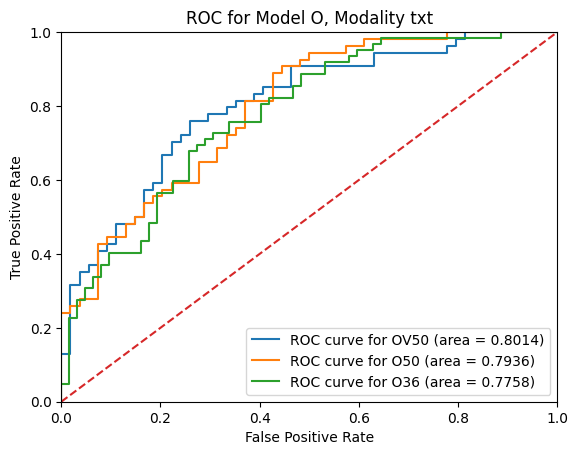

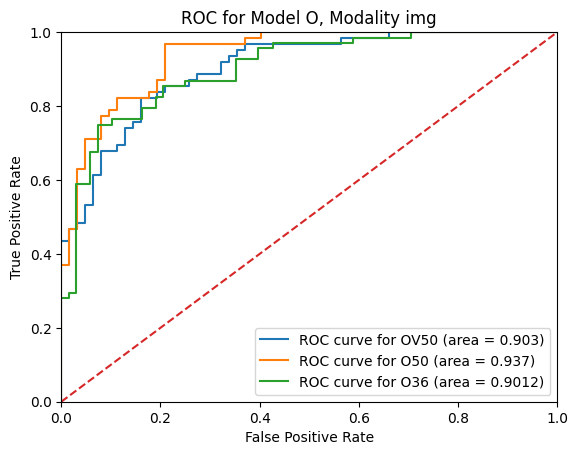

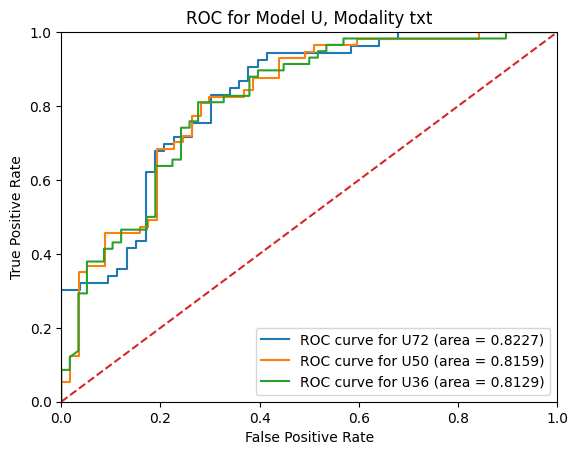

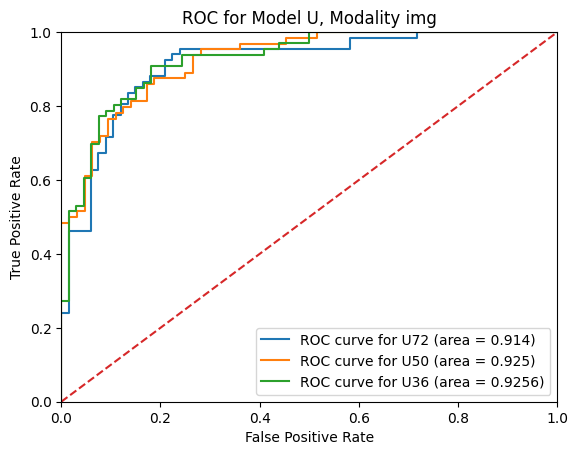

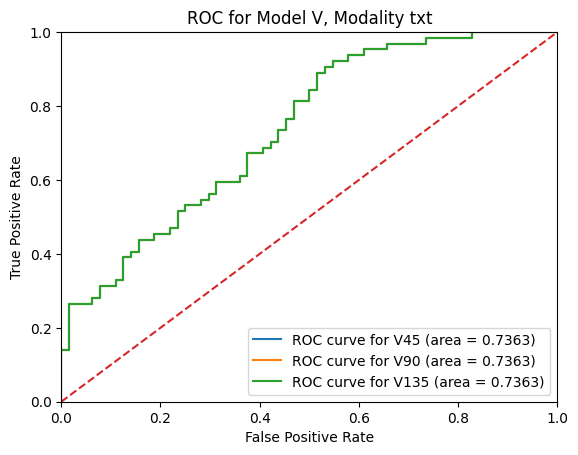

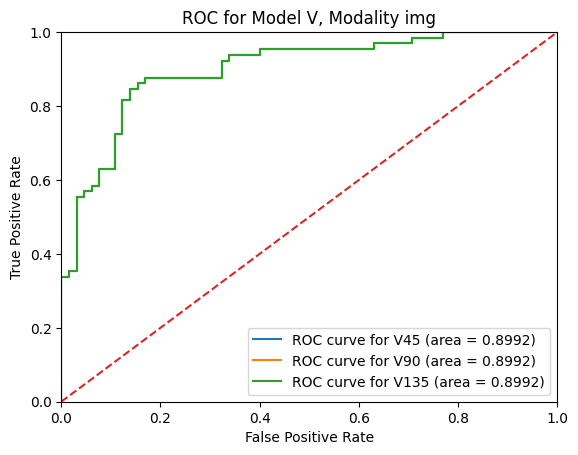

In [ ]:
# # check raw performance
# models = df_long['model_name'].unique()
# for model in models:
#     df_model = df_long[df_long['model_name'] == model].reset_index(drop=True)
#     for modality in ["txt", "img"]:
#         df_model_modality = df_model[df_model['input_modality'] == modality].reset_index(drop=True)
#         for subtype in df_model_modality['model_subtype'].unique():
#             df_model_subtype = df_model_modality[df_model_modality['model_subtype'] == subtype].reset_index(drop=True)

#             y_test = df_model_subtype["label"].values
#             y_scores = df_model_subtype["p"].values
#             ## ROC曲線の描画
#             fpr, tpr, thresholds = roc_curve(y_test, y_scores)
#             plt.plot(fpr, tpr, label=f'ROC curve for {subtype} (area = {round(roc_auc_score(y_test, y_scores), 4)})')
#         plt.plot([0, 1], [0, 1], linestyle='--')
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0, 1.0])
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title(f'ROC for Model {model}, Modality {modality}')
#         plt.legend(loc="lower right")
#         plt.show()

#### MIDAS

In [8]:
df_scope2 = combined_df[
     (combined_df["model_name"]!="attattr")&
      (combined_df["analysis_type"]=="attattr")
].drop_duplicates().reset_index(drop=True)
df_scope2 = df_scope2.rename(columns={"mod": "input_modality"})
df_scope2.head()

,id,input_modality,score,micace,score_pos,score_neg,p_pos,p_neg,model_name,analysis_type,model_subtype,interaction_type
0,1726,txt,-7.027270e-07,0.006276,0.000007,0.000007,0.992601,0.986325,O,attattr,OV50,all
1,2634,txt,-1.827422e-06,0.996531,0.000096,0.000098,0.999385,0.002854,O,attattr,OV50,all
2,2783,txt,-5.818038e-08,0.335680,0.000012,0.000012,0.338589,0.002909,O,attattr,OV50,all
3,3519,txt,-1.605993e-06,0.994688,0.000111,0.000112,0.997842,0.003154,O,attattr,OV50,all
4,3567,txt,6.900736e-07,0.878905,0.000053,0.000052,0.889791,0.010886,O,attattr,OV50,all


In [9]:
df_scope2["label2"] = (df_scope2["p_pos"] - df_scope2["p_neg"] >= 0.5).astype(int)
df_scope2["midas_t"] = df_scope2["score_pos"] - df_scope2["score_neg"]
df_scope2["label2"].value_counts()

,count
label2,
0,2744
1,1712


In [10]:
df_long2 = df_scope2[['id', 'model_name', 'model_subtype', 'input_modality', 'interaction_type', 'label2', 'midas_t']].drop_duplicates().dropna().reset_index(drop=True)
df_long2.head()

,id,model_name,model_subtype,input_modality,interaction_type,label2,midas_t
0,1726,O,OV50,txt,all,0,-7.027270e-07
1,2634,O,OV50,txt,all,1,-1.827422e-06
2,2783,O,OV50,txt,all,0,-5.818038e-08
3,3519,O,OV50,txt,all,1,-1.605993e-06
4,3567,O,OV50,txt,all,1,6.900736e-07


Interaction type: all


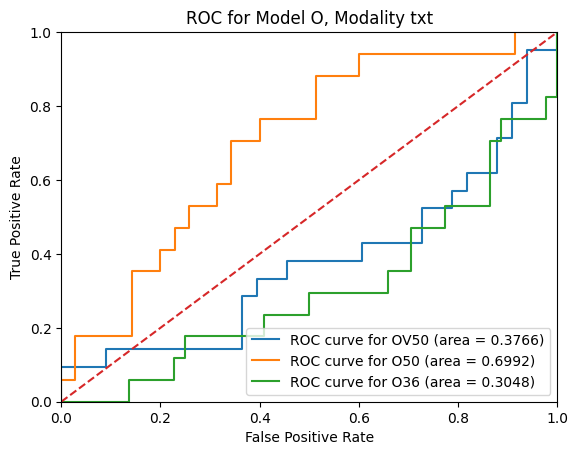

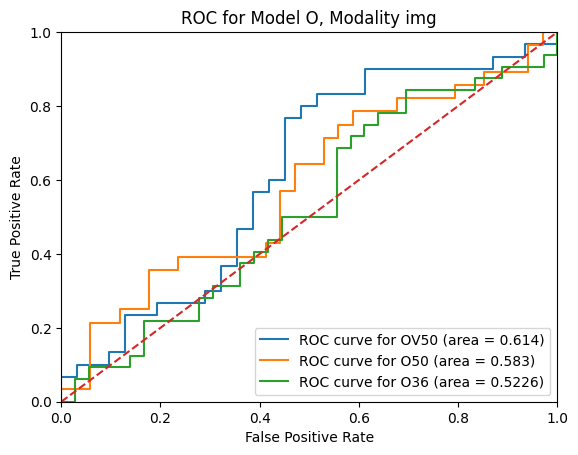

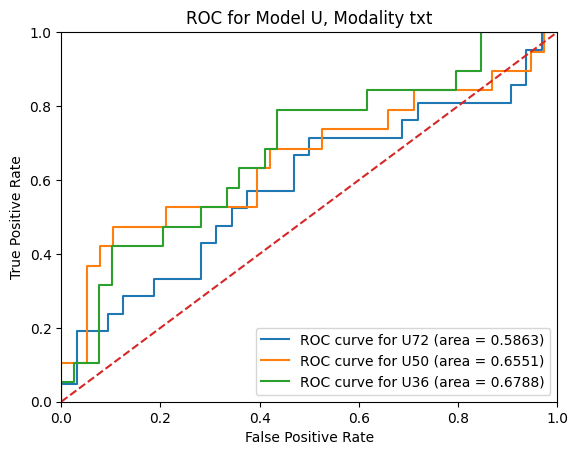

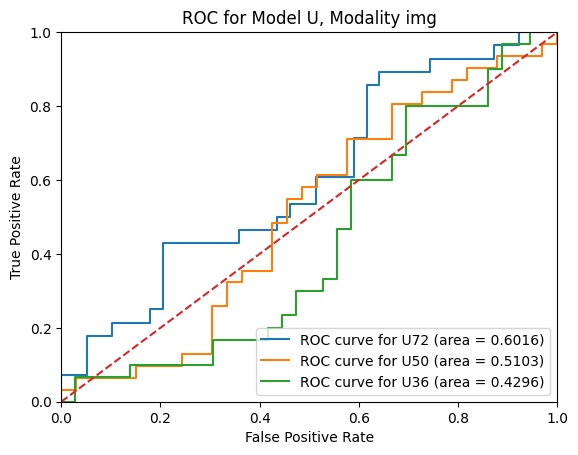

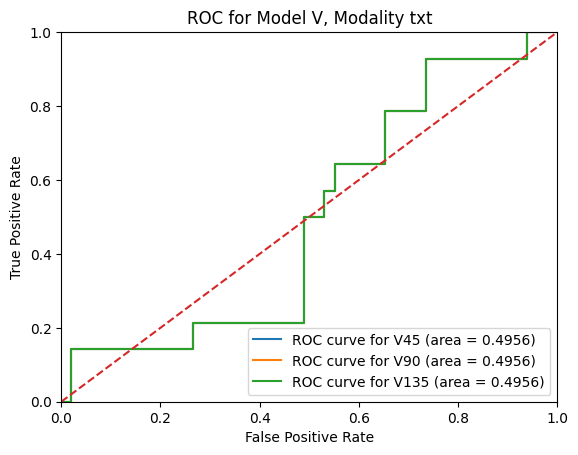

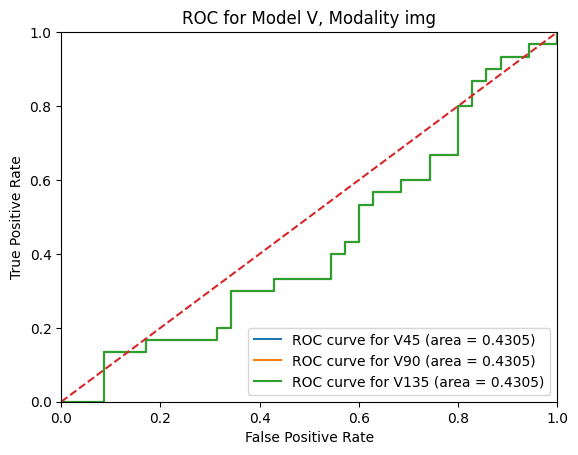

Interaction type: text


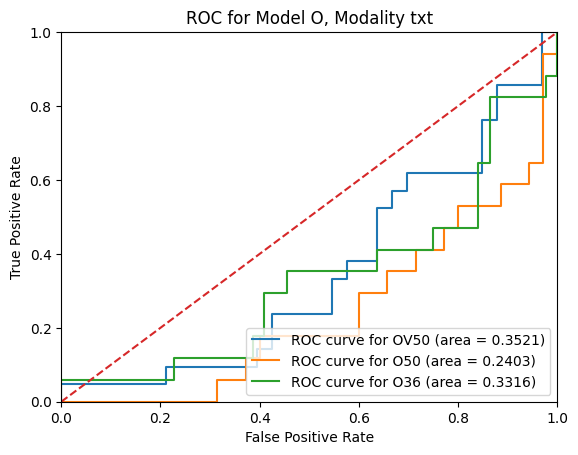

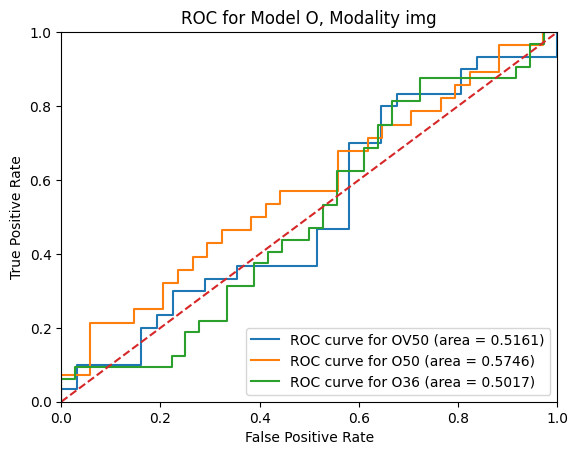

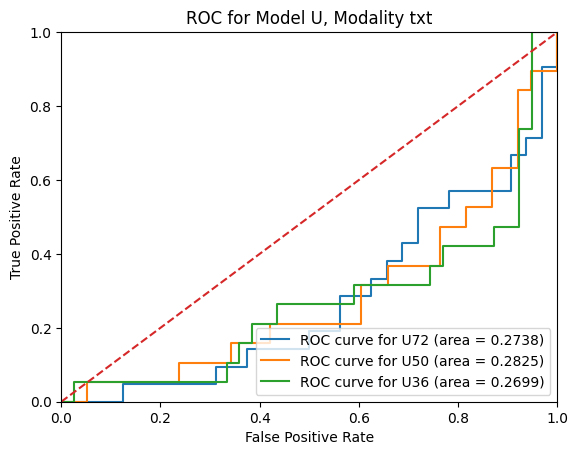

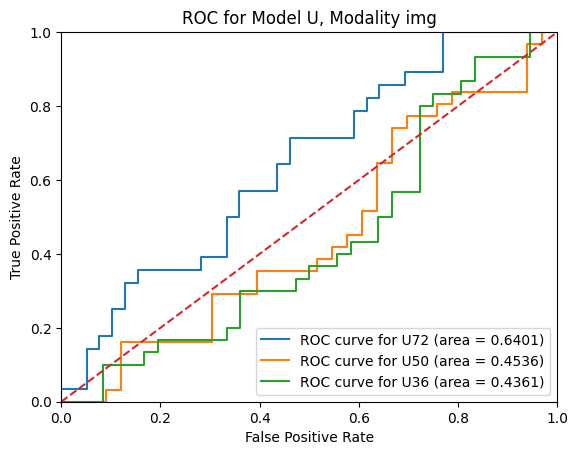

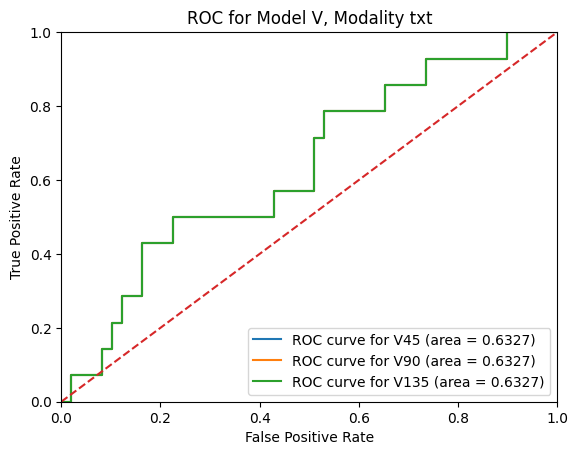

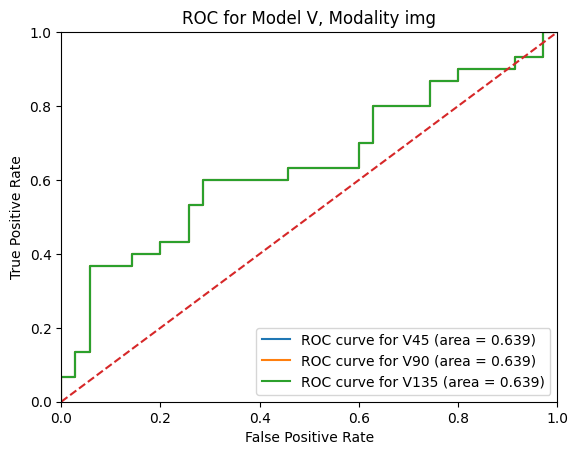

Interaction type: cross


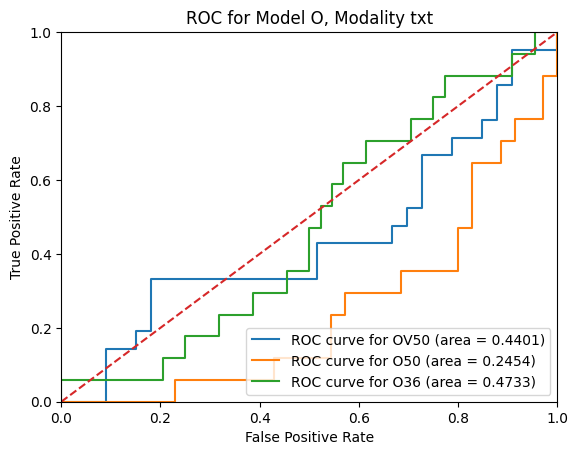

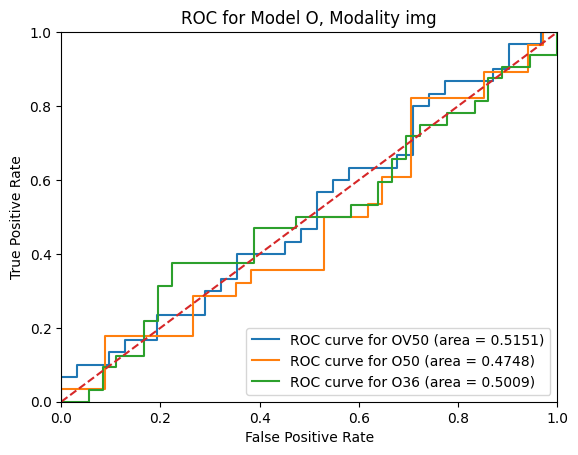

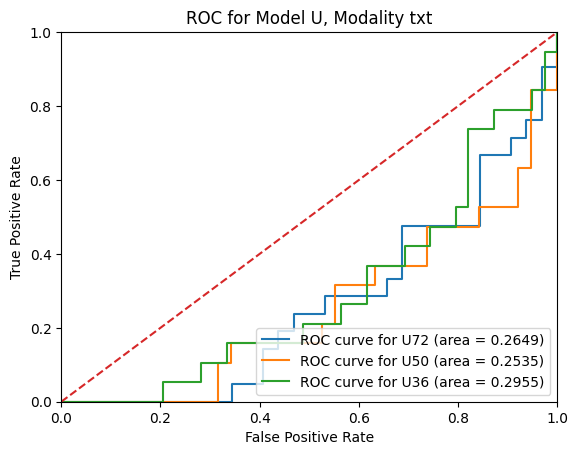

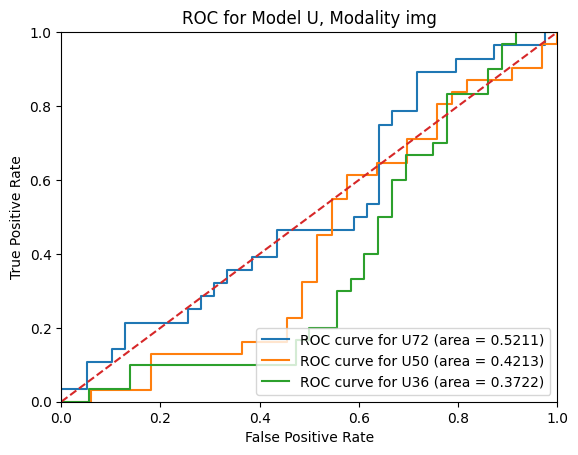

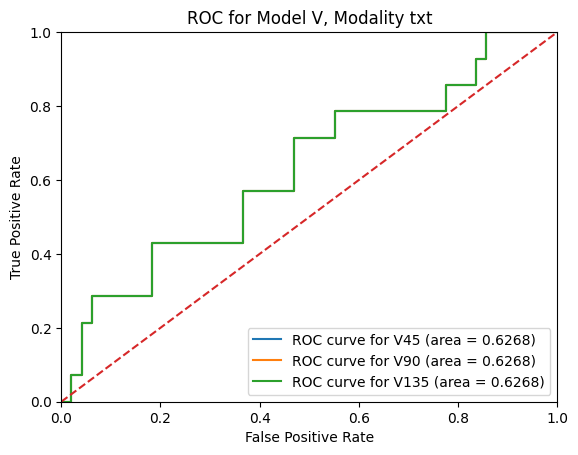

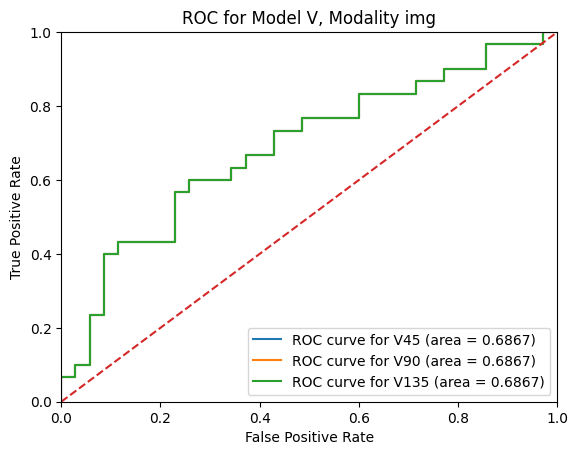

Interaction type: image


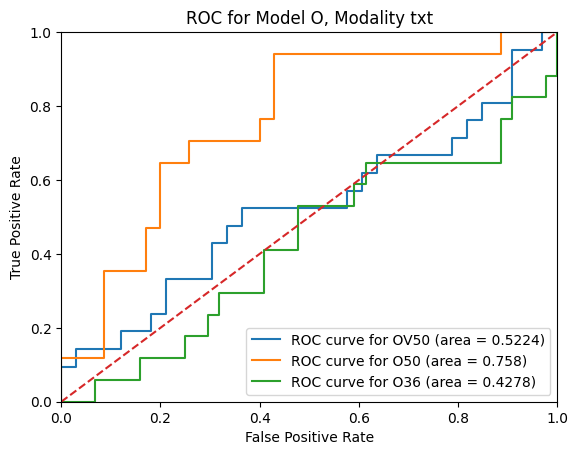

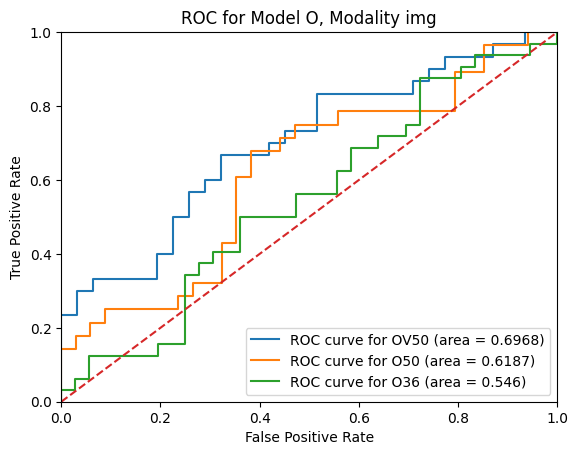

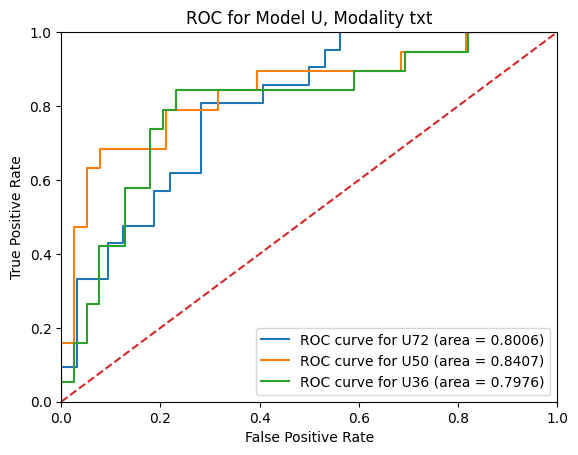

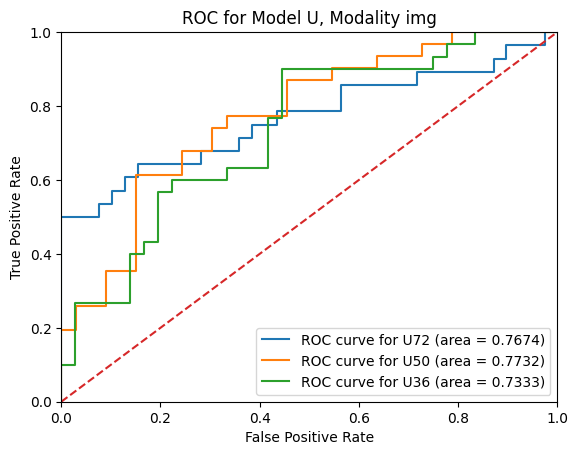

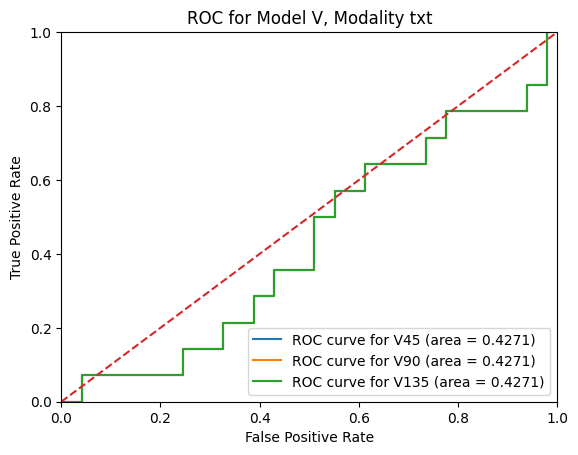

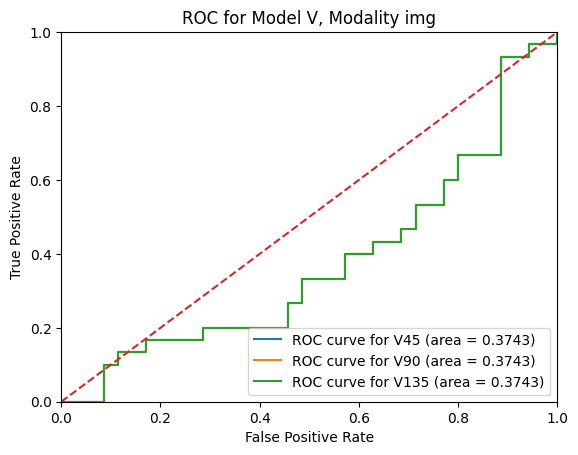

In [ ]:
# # check raw performance
# i_types = df_long2['interaction_type'].unique()
# for i_type in i_types:
#     print(f"Interaction type: {i_type}")
#     df_i_type = df_long2[df_long2['interaction_type'] == i_type].reset_index(drop=True)
#     models = df_i_type['model_name'].unique()
#     for model in models:
#         df_model = df_i_type[df_i_type['model_name'] == model].reset_index(drop=True)
#         for modality in ["txt", "img"]:
#             df_model_modality = df_model[df_model['input_modality'] == modality].reset_index(drop=True)
#             for subtype in df_model_modality['model_subtype'].unique():
#                 df_model_subtype = df_model_modality[df_model_modality['model_subtype'] == subtype].reset_index(drop=True)

#                 y_test = df_model_subtype["label2"].values
#                 y_scores = df_model_subtype["midas_t"].values
#                 ## ROC曲線の描画
#                 fpr, tpr, thresholds = roc_curve(y_test, y_scores)
#                 plt.plot(fpr, tpr, label=f'ROC curve for {subtype} (area = {round(roc_auc_score(y_test, y_scores), 4)})')
#             plt.plot([0, 1], [0, 1], linestyle='--')
#             plt.xlim([0.0, 1.0])
#             plt.ylim([0.0, 1.0])
#             plt.xlabel('False Positive Rate')
#             plt.ylabel('True Positive Rate')
#             plt.title(f'ROC for Model {model}, Modality {modality}')
#             plt.legend(loc="lower right")
#             plt.show()

#### binarize miATE/MIDAS

In [23]:
# Melt the DataFrame to long format
df_scope_1 = df_scope.copy()
df_scope_1["p_diff"] = (df_scope_1["p_pos"] > df_scope_1["p_neg"]).astype(int)
df_scope_1.head()

,id,input_modality,score,micace,score_pos,score_neg,p_pos,p_neg,model_name,analysis_type,model_subtype,interaction_type,p_diff
0,1726,txt,-7.027270e-07,0.006276,0.000007,0.000007,0.992601,0.986325,O,attattr,OV50,all,1
1,2634,txt,-1.827422e-06,0.996531,0.000096,0.000098,0.999385,0.002854,O,attattr,OV50,all,1
2,2783,txt,-5.818038e-08,0.335680,0.000012,0.000012,0.338589,0.002909,O,attattr,OV50,all,1
3,3519,txt,-1.605993e-06,0.994688,0.000111,0.000112,0.997842,0.003154,O,attattr,OV50,all,1
4,3567,txt,6.900736e-07,0.878905,0.000053,0.000052,0.889791,0.010886,O,attattr,OV50,all,1


In [29]:
id_vars = ['id', 'model_name', 'model_subtype', 'input_modality']
df_long_1 = pd.melt(
    df_scope_1,
    id_vars=id_vars,
    value_vars=['p_pos', 'p_neg'],
    var_name='label',
    value_name='p'
).merge(df_scope_1[id_vars+["p_diff"]], on=id_vars)
df_long_1.head()

,id,model_name,model_subtype,input_modality,label,p,p_diff
0,1726,O,OV50,txt,p_pos,0.992601,1
1,2634,O,OV50,txt,p_pos,0.999385,1
2,2783,O,OV50,txt,p_pos,0.338589,1
3,3519,O,OV50,txt,p_pos,0.997842,1
4,3567,O,OV50,txt,p_pos,0.889791,1


In [30]:
# Melt the DataFrame to long format
df_scope_1 = df_scope.copy()
df_scope_1["p_diff"] = (df_scope_1["p_pos"] > df_scope_1["p_neg"]).astype(int)
id_vars = ['id', 'model_name', 'model_subtype', 'input_modality']
df_long_1 = pd.melt(
    df_scope_1,
    id_vars=id_vars,
    value_vars=['p_pos', 'p_neg'],
    var_name='label',
    value_name='p'
).merge(df_scope_1[id_vars+["p_diff"]], on=id_vars)

# Map the labels to 1 and 0
df_long_1['label'] = df_long_1['label'].map({'p_pos': 1, 'p_neg': 0})

# Reorder columns if necessary
df_long_1 = df_long_1[['id', 'model_name', 'model_subtype', 'input_modality', 'label', 'p_diff']].drop_duplicates().reset_index(drop=True)
df_long_1.head()

,id,model_name,model_subtype,input_modality,label,p_diff
0,1726,O,OV50,txt,1,1
1,2634,O,OV50,txt,1,1
2,2783,O,OV50,txt,1,1
3,3519,O,OV50,txt,1,1
4,3567,O,OV50,txt,1,1


# ensemble

## check implementation

### [inference notebook](https://www.kaggle.com/code/muennighoff/hm-inference3)

```
# O
!cd ../vilio; bash ./bash/inference/O/hm_OSA.sh
...
# U
!cd ../vilio; bash ./bash/inference/U/hm_USA.sh
# V
!cd ../vilio; bash ./bash/inference/V/hm_VSA.sh
...
# Combine
!cd ../vilio; bash bash/hm_ens.sh
```
### bash/inference/{O|U|V}/hm_{[O](https://github.com/Muennighoff/vilio/blob/50eb7cc9c901795c394070f7705fc0c5a7667bd2/bash/inference/O/hm_OSA.sh)|[U](https://github.com/Muennighoff/vilio/blob/50eb7cc9c901795c394070f7705fc0c5a7667bd2/bash/inference/U/hm_USA.sh)|[V](https://github.com/Muennighoff/vilio/blob/50eb7cc9c901795c394070f7705fc0c5a7667bd2/bash/inference/V/hm_VSA.sh)}SA.sh
```
# O
...
# Simple Average O-Model outputs
python utils/ens.py --enspath ./data/ --enstype sa --exp O365050

# U
...
# Simple Average
python utils/ens.py --enspath ./data/ --enstype sa --exp U365072

# V
...
# Simple Average
python utils/ens.py --enspath ./data/ --enstype sa --exp VLMDB
```
### [utils/ens.py](https://github.com/Muennighoff/vilio/blob/50eb7cc9c901795c394070f7705fc0c5a7667bd2/utils/ens.py)
```
def simple_average(targets, example, weights=None, power=1, normalize=False):
    """
    targets: df with target values as columns
    example: output df example (e.g. including ID - make sure to adjust iloc below if target is not at 1)
    weights: per submission weights; default is equal weighting
    power: optional for power averaging
    normalize: Whether to normalize targets btw 0 & 1
    """
    if weights is None:
        weights = len(targets.columns) * [1.0 / len(targets.columns)]
    else:
        weights = weights / np.sum(weights)

    preds = example.copy()
    preds.iloc[:,1] = np.zeros(len(preds))

    if normalize:
        targets = (targets - targets.min())/(targets.max()-targets.min())
    for i in range(len(targets.columns)):
        preds.iloc[:,1] = np.add(preds.iloc[:, 1], weights[i] * (targets.iloc[:, i].astype(float)**power))
    
    return preds
```
### [bash/hm_ens.sh](https://github.com/Muennighoff/vilio/blob/50eb7cc9c901795c394070f7705fc0c5a7667bd2/bash/hm_ens.sh)
```
...
# Simple Average
python utils/ens.py --enspath ./data/ --enstype loop --exp ENS
```

### xx
```
def main(path, gt_path="./data/"):
    """
    Loops through Averaging, Power Averaging, Rank Averaging, Optimization to find the best ensemble.

    path: String to directory with csvs of all models
    For each model there should be three csvs: dev, test, test_unseen

    gt_path: Path to folder with ground truth for dev
    """
    # Ground truth
    input_df = pd.read_json(os.path.join(gt_path, 'dev_seen.jsonl'), lines=True)

    # Make sure the lists will be ordered, i.e. test[0] is the same model as devs[0]
    ...

    loop, last_score, delta = 0, 0, 0.1

    while (delta > 0.0001):

        # Individual Roc Aucs
        ...

        for i, column in enumerate(dev_probas):
            score = roc_auc_score(input_df.label, dev_probas.iloc[:, i])
            print(column, score)
        ...

        if loop > 0:
            while len(dev) > 5:
                lowest_score = 1
                drop = 0
                for i, column in enumerate(dev_probas):
                    score = roc_auc_score(input_df.label, dev_probas.iloc[:, i])
                    if score < lowest_score:
                        lowest_score = score
                        col = column
                        drop = i

                column_numbers = [x for x in range(dev_probas.shape[1])]  # list of columns' integer indices
                column_numbers.remove(drop)
                dev_probas = dev_probas.iloc[:, column_numbers]
                ...
    
                if i < len(dev_or):
                    dev_or.pop(drop)
                    test_or.pop(drop)
                    test_unseen_or.pop(drop)
                if i < len(dev):
                    dev.pop(drop)
                    test.pop(drop)
                    test_unseen.pop(drop)
    
                print("Dropped:", col)
                
        # Spearman Correlations:
        print("Spearman Corrs:")
        dev_corr = dev_probas.corr(method='spearman')
        ...

        ### SIMPLE AVERAGE ###
        dev_SA = simple_average(dev_probas, dev[0], power=1, normalize=True)
        ...

        ### POWER AVERAGE ###
        dev_PA = simple_average(dev_probas, dev[0], power=2, normalize=True)
        ...

        ### RANK AVERAGE ###
        dev_RA = rank_average(dev)
        ...

        ### SIMPLEX ###
        weights_dev = Simplex(dev_probas, input_df.label)

        dev_SX = simple_average(dev_probas, dev[0], weights_dev)
        ...

        # Prepare Next Round
        dev = dev_or + [dev_SA, dev_PA, dev_RA, dev_SX]
        test = test_or + [test_SA, test_PA, test_RA, test_SX]
        test_unseen = test_unseen_or + [test_unseen_SA, test_unseen_PA, test_unseen_RA, test_unseen_SX]
                
        dev_probas = pd.concat([df.proba for df in dev], axis=1)
        ...

        # Calculate Delta & increment loop
        delta = abs(roc_auc_score(input_df.label, dev_SX.proba) - last_score)
        last_score = roc_auc_score(input_df.label, dev_SX.proba)

        loop += 1

        # I found the loop to not add any value after 2 rounds.
        if loop == 2:
            break
    
    print("Currently at {} after {} loops.".format(last_score, loop))

    # Get accuracy thresholds & optimize (This does not add value to the roc auc, but just to also have an acc score)
    ...

    # Set path instd of /k/w ; Remove all csv data / load the exact same 3 files again as put out
    # As Simplex at some point simply weighs the highest of all - lets take sx as the final prediction after x loops
    dev_SX.to_csv(os.path.join(path, "FIN_dev_seen_" + args.exp + "_" + str(loop) + ".csv"), index=False)
    ...
```

## function

In [11]:
class _Simplex:
	def __init__(self, pointIndices, testCoords, contentFractions, objectiveScore, opportunityCost, contentFraction, difference):
		self.pointIndices = pointIndices
		self.testCoords = testCoords
		self.contentFractions = contentFractions
		self.contentFraction = contentFraction
		self.__objectiveScore = objectiveScore
		self.__opportunityCost = opportunityCost
		self.update(difference)

	def update(self, difference):
		self.acquisitionValue = -(self.__objectiveScore + (self.__opportunityCost * difference))
		self.difference = difference

	def __eq__(self, other):
		return self.acquisitionValue == other.acquisitionValue

	def __lt__(self, other):
		return self.acquisitionValue < other.acquisitionValue

class SimpleTuner:
	def __init__(self, cornerPoints, objectiveFunction, exploration_preference=0.15, capacity_increment=1000):
		self.capacity_increment = capacity_increment
		self.__cornerPoints = cornerPoints
		self.__numberOfVertices = len(cornerPoints)
		self.queue = []
		self.capacity = self.__numberOfVertices + self.capacity_increment
		self.testPoints = np.empty((self.capacity, self.__numberOfVertices))
		self.objective = objectiveFunction
		self.iterations = 0
		self.maxValue = None
		self.minValue = None
		self.bestCoords = []
		self.opportunityCostFactor = exploration_preference #/ self.__numberOfVertices


	def optimize(self, maxSteps=10):
		for step in range(maxSteps):
			#print(self.maxValue, self.iterations, self.bestCoords)
			if len(self.queue) > 0:
				targetSimplex = self.__getNextSimplex()
				newPointIndex = self.__testCoords(targetSimplex.testCoords)
				for i in range(0, self.__numberOfVertices):
					tempIndex = targetSimplex.pointIndices[i]
					targetSimplex.pointIndices[i] = newPointIndex
					newContentFraction = targetSimplex.contentFraction * targetSimplex.contentFractions[i]
					newSimplex = self.__makeSimplex(targetSimplex.pointIndices, newContentFraction)
					heappush(self.queue, newSimplex)
					targetSimplex.pointIndices[i] = tempIndex
			else:
				testPoint = self.__cornerPoints[self.iterations]
				testPoint.append(0)
				testPoint = np.array(testPoint, dtype=np.float64)
				self.__testCoords(testPoint)
				if self.iterations == (self.__numberOfVertices - 1):
					initialSimplex = self.__makeSimplex(np.arange(self.__numberOfVertices, dtype=np.intp), 1)
					heappush(self.queue, initialSimplex)
			self.iterations += 1

	def get_best(self):
		return (self.maxValue, self.bestCoords[0:-1])

	def __getNextSimplex(self):
		targetSimplex = heappop(self.queue)
		currentDifference = self.maxValue - self.minValue
		while currentDifference > targetSimplex.difference:
			targetSimplex.update(currentDifference)
			# if greater than because heapq is in ascending order
			if targetSimplex.acquisitionValue > self.queue[0].acquisitionValue:
				targetSimplex = heappushpop(self.queue, targetSimplex)
		return targetSimplex

	def __testCoords(self, testCoords):
		objectiveValue = self.objective(testCoords[0:-1])
		if self.maxValue == None or objectiveValue > self.maxValue:
			self.maxValue = objectiveValue
			self.bestCoords = testCoords
			if self.minValue == None: self.minValue = objectiveValue
		elif objectiveValue < self.minValue:
			self.minValue = objectiveValue
		testCoords[-1] = objectiveValue
		if self.capacity == self.iterations:
			self.capacity += self.capacity_increment
			self.testPoints.resize((self.capacity, self.__numberOfVertices))
		newPointIndex = self.iterations
		self.testPoints[newPointIndex] = testCoords
		return newPointIndex


	def __makeSimplex(self, pointIndices, contentFraction):
		vertexMatrix = self.testPoints[pointIndices]
		coordMatrix = vertexMatrix[:, 0:-1]
		barycenterLocation = np.sum(vertexMatrix, axis=0) / self.__numberOfVertices

		differences = coordMatrix - barycenterLocation[0:-1]
		distances = np.sqrt(np.sum(differences * differences, axis=1))
		totalDistance = np.sum(distances)
		barycentricTestCoords = distances / totalDistance

		euclideanTestCoords = vertexMatrix.T.dot(barycentricTestCoords)

		vertexValues = vertexMatrix[:,-1]

		testpointDifferences = coordMatrix - euclideanTestCoords[0:-1]
		testPointDistances = np.sqrt(np.sum(testpointDifferences * testpointDifferences, axis=1))



		inverseDistances = 1 / testPointDistances
		inverseSum = np.sum(inverseDistances)
		interpolatedValue = inverseDistances.dot(vertexValues) / inverseSum


		currentDifference = self.maxValue - self.minValue
		opportunityCost = self.opportunityCostFactor * math.log(contentFraction, self.__numberOfVertices)

		return _Simplex(pointIndices.copy(), euclideanTestCoords, barycentricTestCoords, interpolatedValue, opportunityCost, contentFraction, currentDifference)

	def plot(self):
		if self.__numberOfVertices != 3: raise RuntimeError('Plotting only supported in 2D')
		matrix = self.testPoints[0:self.iterations, :]

		x = matrix[:,0].flat
		y = matrix[:,1].flat
		z = matrix[:,2].flat

		coords = []
		acquisitions = []

		for triangle in self.queue:
			coords.append(triangle.pointIndices)
			acquisitions.append(-1 * triangle.acquisitionValue)


		plt.figure()
		plt.tricontourf(x, y, coords, z)
		plt.triplot(x, y, coords, color='white', lw=0.5)
		plt.colorbar()


		plt.figure()
		plt.tripcolor(x, y, coords, acquisitions)
		plt.triplot(x, y, coords, color='white', lw=0.5)
		plt.colorbar()

		plt.show()

In [12]:
def simple_average(df, prediction_cols=None, weights=None, power=1):
    """
    Calculates the simple (or weighted) power mean of probability columns in the DataFrame.
    Adds a new column 'proba' to the DataFrame with the computed mean.
    Parameters:
        df (pd.DataFrame): Input DataFrame containing probability columns.
        prediction_cols (list): List of column names to use for averaging.
        weights (list or array-like, optional): Weights for weighted mean.
    Must be the same length as the number of probability columns.
        power (float, optional): The exponent specifying the type of power mean to compute.
            Default is 1 (arithmetic mean).
    Returns:
        pd.DataFrame: DataFrame with an additional column 'proba' containing the computed mean.
    """
    if prediction_cols is None:
        raise ValueError("prediction_cols must be provided")
    prob_cols = prediction_cols
    if weights is not None:
        if len(weights) != len(prob_cols):
            raise ValueError("Length of weights must match number of probability columns.")
        if power == 0:
            # Compute weighted geometric mean
            weighted_logs = df[prob_cols].apply(np.log).mul(weights)
            numerator = weighted_logs.sum(axis=1)
            denominator = sum(weights)
            df['proba'] = np.exp(numerator / denominator)
        else:
            # Compute weighted power mean
            numerator = df[prob_cols].pow(power).mul(weights).sum(axis=1)
            denominator = sum(weights)
            df['proba'] = (numerator / denominator).pow(1 / power)
    else:
        if power == 0:
            # Compute geometric mean
            logs = df[prob_cols].apply(np.log)
            numerator = logs.sum(axis=1)
            denominator = len(prob_cols)
            df['proba'] = np.exp(numerator / denominator)
        else:
            # Compute simple (unweighted) power mean
            numerator = df[prob_cols].pow(power).sum(axis=1)
            denominator = len(prob_cols)
            df['proba'] = (numerator / denominator).pow(1 / power)
    return df

# def rank_average(df, prediction_cols=None):
#     """
#     Calculates the rank average of probability columns in the DataFrame.
#     Adds a new column 'proba' to the DataFrame with the computed rank average.
#     Parameters:
#         df (pd.DataFrame): Input DataFrame containing probability columns.
#         prediction_cols (list): List of column names to use for averaging.
#     Returns:
#         pd.DataFrame: DataFrame with an additional column 'proba' containing the rank averaged predictions.
#     """
#     if prediction_cols is None:
#         raise ValueError("prediction_cols must be provided")
#     # Rank each probability column
#     ranked_probs = df[prediction_cols].rank(method='average')
#     # Calculate the average rank
#     avg_rank = ranked_probs.mean(axis=1)
#     # Normalize the average rank to get probabilities between 0 and 1
#     df['proba'] = avg_rank / (len(df) + 1)
#     return df

def rank_average(df, prediction_cols, weights=None):
    """
    Calculates the rank average of probability columns in the DataFrame.
    Adds a new column 'proba' to the DataFrame with the computed rank average.
    Parameters:
        df (pd.DataFrame): Input DataFrame containing probability columns.
        prediction_cols (list): List of column names to use for averaging.
        weights (list or array-like, optional): Weights for weighted mean.
            Must be the same length as the number of probability columns.
    Returns:
        pd.DataFrame: DataFrame with an additional column 'proba' containing the rank averaged predictions.
    """
    if prediction_cols is None:
        raise ValueError("prediction_cols must be provided")
    if weights is None:
        # If weights are not provided, use equal weights
        weights = np.array([1/len(prediction_cols)] * len(prediction_cols))
    else:
        # Ensure weights are numpy array
        weights = np.array(weights)
        # Normalize weights
        total_weight = np.sum(weights)
        weights = weights / total_weight
    # Rank each probability column
    ranked_probs = df[prediction_cols].rank(method='average')
    # Multiply each rank by its corresponding weight
    weighted_ranks = ranked_probs.multiply(weights, axis=1)
    # Sum the weighted ranks
    sum_weighted_ranks = weighted_ranks.sum(axis=1)
    # Normalize the weighted ranks to get probabilities between 0 and 1
    df['proba'] = sum_weighted_ranks / (len(df) + 1)
    return df

# pick-one version
def Simplex(devs, label, prediction_cols=None, df_list=False, exploration=0.01, scale=1):
    """
    Optimizes the weights for model predictions to maximize ROC AUC score.
    Parameters:
        devs (pd.DataFrame or list of DataFrames): Model predictions.
        label (array-like): Ground truth labels.
        prediction_cols (list): List of column names to use for optimization.
        df_list (bool): If True, devs is a list of DataFrames containing 'proba' column.
        exploration (float): Exploration preference for the optimizer.
        scale (int): Scale of the weights.
    Returns:
        list: Optimized weights.
    """
    predictions = []
    if df_list:
        # If devs is a list of DataFrames with 'proba' column
        for df in devs:
            predictions.append(df['proba'])
    else:
        if prediction_cols is None:
            raise ValueError("prediction_cols must be provided")
        # If devs is a DataFrame with model prediction columns
        for col in prediction_cols:
            predictions.append(devs[col])
    print("Optimizing {} inputs.".format(len(predictions)))
    def roc_auc(weights):
        '''Objective function to maximize ROC AUC score given weights'''
        final_prediction = 0
        for weight, prediction in zip(weights, predictions):
                final_prediction += weight * prediction
        return roc_auc_score(label, final_prediction)
    # Define the search area and optimizer parameters
    zero_vtx = np.zeros((1, len(predictions)), dtype=int)
    optimization_domain_vertices = np.identity(len(predictions), dtype=int) * scale
    optimization_domain_vertices = np.concatenate((zero_vtx, optimization_domain_vertices), axis=0).tolist()
    number_of_iterations = 3000
    # Initialize SimpleTuner for optimization
    tuner = SimpleTuner(optimization_domain_vertices, roc_auc, exploration_preference=exploration)
    tuner.optimize(number_of_iterations)
    best_objective_value, best_weights = tuner.get_best()
    print('Optimized ROC AUC =', best_objective_value)  # Same as roc_auc(best_weights)
    print('Optimized Weights =', best_weights)
    return best_weights

# combination version
def SimplexComb(devs, label, prediction_cols=None, df_list=False):
    """
    Optimizes the weights for model predictions to maximize ROC AUC score using continuous weights.
    Parameters:
        devs (pd.DataFrame or list of DataFrames): Model predictions.
        label (array-like): Ground truth labels.
        prediction_cols (list): List of column names to use for optimization.
        df_list (bool): If True, devs is a list of DataFrames containing 'proba' column.
    Returns:
        list: Optimized weights.
    """
    predictions = []
    if df_list:
        for df in devs:
            predictions.append(pd.to_numeric(df['proba'], errors='raise').values)
    else:
        if prediction_cols is None:
            raise ValueError("prediction_cols must be provided")
        for col in prediction_cols:
            predictions.append(pd.to_numeric(devs[col], errors='raise').values)
    print("Optimizing {} inputs.".format(len(predictions)))
    def neg_roc_auc(weights):
        '''Objective function to minimize negative ROC AUC score given weights'''
        final_prediction = np.zeros_like(predictions[0], dtype=float)
        for weight, prediction in zip(weights, predictions):
            final_prediction += weight * prediction
        return -roc_auc_score(label, final_prediction)
    # Initial guess: equal weights
    x0 = np.ones(len(predictions)) / len(predictions)
    # Constraints: weights sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    # Bounds: weights between 0 and 1
    bounds = [(0, 1) for _ in range(len(predictions))]
    # Optimize
    result = minimize(neg_roc_auc, x0, method='SLSQP', bounds=bounds, constraints=constraints)
    best_weights = result.x
    best_score = -result.fun
    print('Optimized ROC AUC =', best_score)
    print('Optimized Weights =', best_weights)
    return best_weights

In [13]:
def optimize(input_df_or_dfs, simplex_mode="pick_one"):
    # Process input data
    if len(input_df_or_dfs) == 2:
        train_df, test_df = input_df_or_dfs
    else:
        train_df = input_df_or_dfs
        test_df = None
    # Initialize loop variables
    loop, last_score, delta = 0, 0, 0.1
    # Identify model prediction columns by excluding 'id' and 'label'
    columns_to_exclude = ['label']
    if 'id' in train_df.columns:
        columns_to_exclude.append('id')
    prediction_cols = [col for col in train_df.columns if col not in columns_to_exclude]
    # Keep track of original model columns
    original_model_cols = prediction_cols.copy()
    # Separate predictions and labels
    dev_probas = train_df[prediction_cols].copy()
    dev_probas = dev_probas.apply(pd.to_numeric, errors='raise')  # Ensure numeric
    labels = pd.to_numeric(train_df['label'].copy())  # Ensure numeric
    # Keep a copy of the original predictions
    dev_or = [dev_probas.copy()]
    final_prediction_cols = None  # Initialize for later use
    final_weights_dev = None
    # Start ensemble optimization loop
    while delta > 0.0001:
        print(f"\nLoop {loop + 1}:")
        # # Calculate individual ROC AUC scores
        # print("Individual ROC AUC Scores:")
        individual_scores = {}
        for column in dev_probas.columns:
            score = roc_auc_score(labels, dev_probas[column])
            individual_scores[column] = score
            # print(f"{column}: {score}")
        # If it's not the first loop and more than 5 models, drop the lowest scoring models to keep top 5
        if loop > 0 and len(original_model_cols) > 5:
            while len(original_model_cols) > 5:
                # Find the column with the lowest ROC AUC score among original model columns
                scores = {column: individual_scores[column] for column in original_model_cols}
                drop_col = min(scores, key=scores.get)
                # Drop the column with the lowest score
                dev_probas.drop(columns=drop_col, inplace=True)
                dev_or[0].drop(columns=drop_col, inplace=True)
                original_model_cols.remove(drop_col)
                print(f"Dropped: {drop_col}")
        # # Calculate Spearman correlations
        # print("\nSpearman Correlations:")
        # dev_corr = dev_probas.corr(method='spearman')
        # print(dev_corr)
        # Prepare DataFrames for ensemble methods
        # Make copies to avoid modifying original DataFrames
        dev_SA = dev_probas.copy()
        dev_PA = dev_probas.copy()
        dev_RA = dev_probas.copy()
        dev_WRA = dev_probas.copy()
        dev_SX = dev_probas.copy()
        # Use the current list of original model columns
        current_prediction_cols = original_model_cols.copy()
        ### SIMPLE AVERAGE ###
        dev_SA = simple_average(dev_SA, prediction_cols=current_prediction_cols, power=1)
        ### POWER AVERAGE ###
        dev_PA = simple_average(dev_PA, prediction_cols=current_prediction_cols, power=2)
        ### RANK AVERAGE ###
        dev_RA = rank_average(dev_RA, prediction_cols=current_prediction_cols)
        ### SIMPLEX ###
        # Get optimized weights using Simplex
        if simplex_mode == "pick_one":
            weights_dev = Simplex(dev_probas, labels, prediction_cols=current_prediction_cols)
        else:
            weights_dev = SimplexComb(dev_probas, labels, prediction_cols=current_prediction_cols)
        # Assume weights_dev is an ordered np.array corresponding to current_prediction_cols
        ### WEIGHTED RANK AVERAGE ###
        dev_WRA = rank_average(dev_WRA, prediction_cols=current_prediction_cols, weights=weights_dev)
        ### WEIGHTED SIMPLE AVERAGE ###
        dev_SX = simple_average(dev_SX, prediction_cols=current_prediction_cols, weights=weights_dev)
        # Prepare for the next round by combining ensembles
        # Rename 'proba' columns to identify ensemble methods
        dev_list = []
        dev_list += dev_or  # Original models
        dev_SA_renamed = dev_SA[['proba']].rename(columns={'proba': 'SA'})
        dev_PA_renamed = dev_PA[['proba']].rename(columns={'proba': 'PA'})
        dev_RA_renamed = dev_RA[['proba']].rename(columns={'proba': 'RA'})
        dev_WRA_renamed = dev_WRA[['proba']].rename(columns={'proba': 'WRA'})
        dev_SX_renamed = dev_SX[['proba']].rename(columns={'proba': 'SX'})
        dev_list.append(dev_SA_renamed)
        dev_list.append(dev_PA_renamed)
        dev_list.append(dev_RA_renamed)
        dev_list.append(dev_WRA_renamed)
        dev_list.append(dev_SX_renamed)
        # Concatenate all models and ensemble predictions
        dev_probas = pd.concat(dev_list, axis=1)
        # Update prediction_cols to include ensemble methods for the next iteration
        prediction_cols = dev_probas.columns.tolist()
        # Calculate delta using the ROC AUC of the simplex ensemble
        current_score = roc_auc_score(labels, dev_SX_renamed['SX'])
        delta = abs(current_score - last_score)
        print(f"\nSimplex Ensemble ROC AUC: {current_score}")
        print(f"Delta: {delta}")
        last_score = current_score
        loop += 1
        # Limit the loop to 2 iterations as per the original code
        if loop == 2:
            break
    print("\nFinal Optimized Ensemble ROC AUC Score:")
    print(f"{last_score}")
    # Save final columns and weights
    final_prediction_cols = current_prediction_cols.copy()
    final_weights_dev = weights_dev.copy()
    # Calculate and print ROC AUC scores for each ensemble method
    print("\nEnsemble Methods ROC AUC Scores on Training Data:")
    sa_score = roc_auc_score(labels, dev_SA_renamed['SA'])
    pa_score = roc_auc_score(labels, dev_PA_renamed['PA'])
    ra_score = roc_auc_score(labels, dev_RA_renamed['RA'])
    wra_score = roc_auc_score(labels, dev_WRA_renamed['WRA'])
    sx_score = roc_auc_score(labels, dev_SX_renamed['SX'])
    print(f"Simple Average: {sa_score}")
    print(f"Power Average: {pa_score}")
    print(f"Rank Average: {ra_score}")
    print(f"Weighted Rank Average: {wra_score}")
    print(f"Simplex Ensemble: {sx_score}")
    # Print final individual model ROC AUC scores
    # print("\nFinal Individual Model ROC AUC Scores on Training Data:")
    for column in final_prediction_cols:
        score = roc_auc_score(labels, dev_probas[column])
        print(f"{column}: {score}")
    if test_df is not None:
        # Apply the optimized ensemble to test_df
        columns_to_exclude = ['label']
        if 'id' in test_df.columns:
            columns_to_exclude.append('id')
        test_prediction_cols = [col for col in test_df.columns if col not in columns_to_exclude]
        # Ensure test_prediction_cols match final_prediction_cols
        test_prediction_cols = [col for col in test_prediction_cols if col in final_prediction_cols]
        if len(test_prediction_cols) < len(final_prediction_cols):
            missing_cols = set(final_prediction_cols) - set(test_prediction_cols)
            print(f"Warning: The following columns are missing in test_df: {missing_cols}")
        # Get test_probas
        test_probas = test_df[test_prediction_cols].copy()
        test_probas = test_probas.apply(pd.to_numeric, errors='raise')  # Ensure numeric
        # Apply the ensemble methods to test data
        test_SA = simple_average(test_probas.copy(), prediction_cols=test_prediction_cols, power=1)
        test_PA = simple_average(test_probas.copy(), prediction_cols=test_prediction_cols, power=2)
        test_RA = rank_average(test_probas.copy(), prediction_cols=test_prediction_cols)
        test_WRA = rank_average(test_probas.copy(), prediction_cols=test_prediction_cols, weights=final_weights_dev)
        test_SX = simple_average(test_probas.copy(), prediction_cols=test_prediction_cols, weights=final_weights_dev)
        # If 'label' exists in test_df, calculate and print ROC AUC
        if 'label' in test_df.columns:
            test_labels = pd.to_numeric(test_df['label'].copy())  # Ensure numeric
            print("\nEnsemble Methods ROC AUC Scores on Test Data:")
            sa_score_test = roc_auc_score(test_labels, test_SA['proba'])
            pa_score_test = roc_auc_score(test_labels, test_PA['proba'])
            ra_score_test = roc_auc_score(test_labels, test_RA['proba'])
            wra_score_test = roc_auc_score(test_labels, test_WRA['proba'])
            sx_score_test = roc_auc_score(test_labels, test_SX['proba'])
            print(f"Simple Average: {sa_score_test}")
            print(f"Power Average: {pa_score_test}")
            print(f"Rank Average: {ra_score_test}")
            print(f"Weighted Rank Average: {wra_score_test}")
            print(f"Simplex Ensemble: {sx_score_test}")
            # Print individual model ROC AUC scores
            # print("\nIndividual Model ROC AUC Scores on Test Data:")
            for column in test_prediction_cols:
                score = roc_auc_score(test_labels, test_probas[column])
                print(f"{column}: {score}")
        else:
            print("\nNote: 'label' column not found in test_df. ROC AUC cannot be calculated.")
        # Return the ensemble predictions
        return test_SX
    else:
        # Return the final ensemble predictions on train_df
        return dev_SX

In [ ]:
# def convert_df(df, export_cols = ['id', 'label', 'input_modality']):
#     """
#     Converts a long-format DataFrame into a dictionary of wide-format DataFrames
#     grouped by 'model_name'. Each DataFrame in the dictionary is pivoted on 'model_subtype',
#     with probabilities 'p' as the values.

#     Parameters:
#         df (pd.DataFrame): Input DataFrame with columns ['id', 'model_name', 'model_subtype', 'label', 'p']

#     Returns:
#         dict: Dictionary where keys are 'model_name' and values are pivoted DataFrames
#     """
#     # Initialize an empty dictionary to hold the DataFrames per model_name
#     model_dict = {}

#     # Get unique model_names
#     model_names = df['model_name'].unique()

#     for name in model_names:
#         # Filter the DataFrame for the current model_name
#         df_model = df[df['model_name'] == name]

#         # Pivot the DataFrame to wide format
#         df_pivot = df_model.pivot_table(
#             index=export_cols,
#             columns='model_subtype',
#             values='p'
#         ).reset_index()

#         # Flatten the column index resulting from pivot (if necessary)
#         df_pivot.columns.name = None  # Remove the 'model_subtype' name

#         # Rename the probability columns to include 'p_' prefix
#         # p_columns = [f'p_{col}' for col in df_pivot.columns if col not in ['id', 'label']]
#         p_dict = {col: f'p_{col}' for col in df_pivot.columns if col not in export_cols}
#         # df_pivot.rename(columns=p_columns, inplace=True)
#         # df_pivot.rename(columns={col: f'p_{col}' for col in p_columns}, inplace=True)
#         df_pivot.rename(columns=p_dict, inplace=True)

#         # Sort columns for consistency
#         # print(df_pivot.columns)
#         # print(['id', 'label'] + sorted(p_columns, key=lambda x: x))
#         # df_pivot = df_pivot[['id', 'label'] + sorted(p_columns, key=lambda x: x)]
#         df_pivot = df_pivot[export_cols + sorted(list(p_dict.values()))]

#         # Add the DataFrame to the dictionary
#         model_dict[name] = df_pivot.dropna()

#     return model_dict

In [ ]:
# def convert_df(df, export_cols = ['id', 'label2', 'input_modality'], pivot_col = "score_type", pivot_value = 'midas_t'):
#     """
#     Converts a long-format DataFrame into a dictionary of wide-format DataFrames
#     grouped by 'model_name'. Each DataFrame in the dictionary is pivoted on 'model_subtype',
#     with probabilities 'p' as the values.

#     Parameters:
#         df (pd.DataFrame): Input DataFrame with columns ['id', 'model_name', 'model_subtype', 'label', 'p']

#     Returns:
#         dict: Dictionary where keys are 'model_name' and values are pivoted DataFrames
#     """
#     # Initialize an empty dictionary to hold the DataFrames per model_name
#     model_dict = {}

#     # Get unique model_names
#     model_names = df['model_name'].unique()

#     for name in model_names:
#         # Filter the DataFrame for the current model_name
#         df_model = df[df['model_name'] == name]
#         # Pivot the DataFrame to wide format
#         df_pivot = df_model.pivot_table(
#             index=export_cols,
#             columns=pivot_col,
#             values=pivot_value
#         ).reset_index()

#         # Flatten the column index resulting from pivot (if necessary)
#         df_pivot.columns.name = None  # Remove the 'model_subtype' name

#         # Rename the probability columns to include 'p_' prefix
#         # p_columns = [f'p_{col}' for col in df_pivot.columns if col not in ['id', 'label']]
#         p_dict = {col: f'p_{col}' for col in df_pivot.columns if col not in export_cols}
#         # df_pivot.rename(columns=p_columns, inplace=True)
#         # df_pivot.rename(columns={col: f'p_{col}' for col in p_columns}, inplace=True)
#         df_pivot.rename(columns=p_dict, inplace=True)

#         # Sort columns for consistency
#         # print(df_pivot.columns)
#         # print(['id', 'label'] + sorted(p_columns, key=lambda x: x))
#         # df_pivot = df_pivot[['id', 'label'] + sorted(p_columns, key=lambda x: x)]
#         df_pivot = df_pivot[export_cols + sorted(list(p_dict.values()))]

#         # Add the DataFrame to the dictionary
#         model_dict[name] = df_pivot.dropna()

#     return model_dict

In [ ]:
def convert_df(df, export_cols = ['id', 'label2', 'input_modality'], model_col="model_name", pivot_col = "interaction_type", pivot_value = 'midas_t'):
    """
    Converts a long-format DataFrame into a dictionary of wide-format DataFrames
    grouped by 'model_name'. Each DataFrame in the dictionary is pivoted on 'model_subtype',
    with probabilities 'p' as the values.

    Parameters:
        df (pd.DataFrame): Input DataFrame with columns ['id', 'model_name', 'model_subtype', 'label', 'p']

    Returns:
        dict: Dictionary where keys are 'model_name' and values are pivoted DataFrames
    """
    # Initialize an empty dictionary to hold the DataFrames per model_name
    model_dict = {}

    # Get unique model_names
    model_names = df[model_col].unique()

    for name in model_names:
        # Filter the DataFrame for the current model_name
        df_model = df[df[model_col] == name]
        # Pivot the DataFrame to wide format
        df_pivot = df_model.pivot_table(
            index=export_cols,
            columns=pivot_col,
            values=pivot_value
        ).reset_index()

        # Flatten the column index resulting from pivot (if necessary)
        df_pivot.columns.name = None  # Remove the 'model_subtype' name

        # Rename the probability columns to include 'p_' prefix
        # p_columns = [f'p_{col}' for col in df_pivot.columns if col not in ['id', 'label']]
        p_dict = {col: f'p_{col}' for col in df_pivot.columns if col not in export_cols}
        # df_pivot.rename(columns=p_columns, inplace=True)
        # df_pivot.rename(columns={col: f'p_{col}' for col in p_columns}, inplace=True)
        df_pivot.rename(columns=p_dict, inplace=True)

        # Sort columns for consistency
        # print(df_pivot.columns)
        # print(['id', 'label'] + sorted(p_columns, key=lambda x: x))
        # df_pivot = df_pivot[['id', 'label'] + sorted(p_columns, key=lambda x: x)]
        df_pivot = df_pivot[export_cols + sorted(list(p_dict.values()))]

        # Add the DataFrame to the dictionary
        model_dict[name] = df_pivot.dropna()

    return model_dict

## miATE

### all-in-one ensemble

#### task-wise

In [ ]:
print("Data conversion")
df_all = df_long.copy()
# df_all["id"] = df_all["id"].astype(str) + "_" + df_all["input_modality"].astype(str)
# model_dict = convert_df(df_all)
model_dict = convert_df(df_all, export_cols = ['id', 'label', 'input_modality'], pivot_col = "model_subtype", pivot_value = 'p')
print("Intra-model ensemble")
# Loop through each model_name and apply the functions
for model_name, df_model in model_dict.items():
    prediction_cols = df_model.columns[df_model.columns.str.contains("p_")]
    # Apply simple average
    df_model = simple_average(df_model, prediction_cols=prediction_cols, weights=None).drop(prediction_cols, axis=1).rename(columns={"proba": f"p_{model_name}"})
    if model_name==list(model_dict.keys())[0]:
        df_models = df_model.drop_duplicates()
    else:
        df_models = df_models.merge(df_model, on=["id", "label", "input_modality"], how="inner").drop_duplicates()
print("Inter-model ensemble")
df_models["id"] = df_models["id"].astype(str) + "_" + df_models["label"].astype(str)
df_models = df_models.drop(["input_modality"], axis=1)
id_all = df_models["id"].unique()
id_train, id_test = train_test_split(id_all, test_size=0.2, random_state=RS)
df_train = df_models[df_models["id"].isin(id_train)].reset_index(drop=True)
df_test = df_models[df_models["id"].isin(id_test)].reset_index(drop=True)
# dfs = train_test_split(df_models, test_size=0.2, random_state=RS)
print(f"(Train, Test) = {len(df_train)}, {len(df_test)}")
# df_result = optimize(df_models)# .drop("p_U", axis=1)[["id", "label", "p_V", "p_O"]]
df_result = optimize((df_train, df_test))# .drop("p_U", axis=1)[["id", "label", "p_V", "p_O"]]
print("=====================")

Data conversion
Intra-model ensemble
Inter-model ensemble
(Train, Test) = 141, 33

Loop 1:
Optimizing 3 inputs.
Optimized ROC AUC = 0.9462127316680098
Optimized Weights = [0. 1. 0.]

Simplex Ensemble ROC AUC: 0.9462127316680098
Delta: 0.9462127316680098

Loop 2:
Optimizing 3 inputs.
Optimized ROC AUC = 0.9462127316680098
Optimized Weights = [0. 1. 0.]

Simplex Ensemble ROC AUC: 0.9462127316680098
Delta: 0.0

Final Optimized Ensemble ROC AUC Score:
0.9462127316680098

Ensemble Methods ROC AUC Scores on Training Data:
Simple Average: 0.9327155519742143
Power Average: 0.9309024979854956
Rank Average: 0.9438960515713135
Weighted Rank Average: 0.9462127316680098
Simplex Ensemble: 0.9462127316680098
p_O: 0.9202256244963739
p_U: 0.9462127316680098
p_V: 0.8817485898468976

Ensemble Methods ROC AUC Scores on Test Data:
Simple Average: 0.9360902255639098
Power Average: 0.9360902255639098
Rank Average: 0.9360902255639098
Weighted Rank Average: 0.9511278195488722
Simplex Ensemble: 0.95112781954887

#### intra-model

In [ ]:
print("Data conversion")
df_all = df_long.copy()
# df_all["id"] = df_all["id"].astype(str) + "_" + df_all["input_modality"].astype(str)
# model_dict = convert_df(df_all)
model_dict = convert_df(df_all, export_cols = ['id', 'label', 'input_modality'], pivot_col = "model_subtype", pivot_value = 'p')
print("Intra-model ensemble")
# Loop through each model_name and apply the functions
for model_name, df_model in model_dict.items():
    print(f"Model {model_name}")
    df_model = df_model.drop(["input_modality"], axis=1)
    id_all = df_model["id"].unique()
    id_train, id_test = train_test_split(id_all, test_size=0.2, random_state=RS)
    df_train = df_model[df_model["id"].isin(id_train)].reset_index(drop=True)
    df_test = df_model[df_model["id"].isin(id_test)].reset_index(drop=True)
    # dfs = train_test_split(df_model, test_size=0.2, random_state=RS)
    print(f"(train, test) = {len(df_train)}, {len(df_test)}")
    df_result = optimize((df_train, df_test))
    print("---------------------")


Data conversion
Intra-model ensemble
Model O
(train, test) = 168, 42

Loop 1:
Optimizing 3 inputs.
Optimized ROC AUC = 0.8959750566893424
Optimized Weights = [0.49870476 0.49870476 0.00171461]

Simplex Ensemble ROC AUC: 0.8959750566893424
Delta: 0.8959750566893424

Loop 2:
Optimizing 3 inputs.
Optimized ROC AUC = 0.8959750566893424
Optimized Weights = [0.49870476 0.49870476 0.00171461]

Simplex Ensemble ROC AUC: 0.8959750566893424
Delta: 0.0

Final Optimized Ensemble ROC AUC Score:
0.8959750566893424

Ensemble Methods ROC AUC Scores on Training Data:
Simple Average: 0.8929988662131518
Power Average: 0.8921485260770975
Rank Average: 0.8983134920634921
Weighted Rank Average: 0.9005102040816326
Simplex Ensemble: 0.8959750566893424
p_O36: 0.8842120181405896
p_O50: 0.8932823129251699
p_OV50: 0.8791099773242631

Ensemble Methods ROC AUC Scores on Test Data:
Simple Average: 0.9160997732426304
Power Average: 0.9229024943310657
Rank Average: 0.9342403628117913
Weighted Rank Average: 0.909297052

### task-wise ensemble

In [ ]:
ens_dict = {}
for modality in df_long["input_modality"].unique():
    print(f"Pipeline for {modality}")
    print("Data conversion")
    df_modality = df_long[df_long["input_modality"] == modality].reset_index(drop=True)
    model_dict = convert_df(df_modality)
    print("Intra-model ensemble")
    # Loop through each model_name and apply the functions
    for model_name, df_model in model_dict.items():
        prediction_cols = df_model.columns[df_model.columns.str.contains("p_")]
        # Apply simple average
        df_model = simple_average(df_model, prediction_cols=prediction_cols, weights=None).drop(prediction_cols, axis=1).rename(columns={"proba": f"p_{model_name}"})
        if model_name==list(model_dict.keys())[0]:
            df_models = df_model.copy()
        else:
            df_models = df_models.merge(df_model, on=["id", "label"], how="inner")
    print("Inter-model ensemble")
    df_models["id"] = df_models["id"].astype(str) + "_" + df_models["label"].astype(str)
    dfs = train_test_split(df_models, test_size=0.2, random_state=RS)
    # df_result = optimize(df_models)# .drop("p_U", axis=1)[["id", "label", "p_V", "p_O"]]
    df_result = optimize(dfs)# .drop("p_U", axis=1)[["id", "label", "p_V", "p_O"]]
    ens_dict[modality] = df_result.copy()
    print("=====================")

Pipeline for txt
Data conversion
Intra-model ensemble
Inter-model ensemble

Loop 1:
Optimizing 3 inputs.
Optimized ROC AUC = 0.913265306122449
Optimized Weights = [0. 1. 0.]

Simplex Ensemble ROC AUC: 0.913265306122449
Delta: 0.913265306122449

Loop 2:
Optimizing 3 inputs.
Optimized ROC AUC = 0.913265306122449
Optimized Weights = [0. 1. 0.]

Simplex Ensemble ROC AUC: 0.913265306122449
Delta: 0.0

Final Optimized Ensemble ROC AUC Score:
0.913265306122449

Ensemble Methods ROC AUC Scores on Training Data:
Simple Average: 0.8903061224489797
Power Average: 0.889030612244898
Rank Average: 0.8941326530612246
Weighted Rank Average: 0.913265306122449
Simplex Ensemble: 0.913265306122449
p_O: 0.8826530612244898
p_U: 0.913265306122449
p_V: 0.8099489795918368

Ensemble Methods ROC AUC Scores on Test Data:
Simple Average: 0.8571428571428572
Power Average: 0.8571428571428572
Rank Average: 0.8775510204081632
Weighted Rank Average: 0.9183673469387755
Simplex Ensemble: 0.9183673469387755
p_O: 0.8775510

In [ ]:
# df_txt = df_long[df_long["input_modality"] == "txt"].reset_index(drop=True)
# df_img = df_long[df_long["input_modality"] == "img"].reset_index(drop=True)
# df_txt[df_txt["id"]==1726].sort_values(by=["model_name", "model_subtype"])
# df_txt[df_txt["id"]==2634].sort_values(by=["model_name", "model_subtype"])
# model_dict = convert_df(df_txt)
# model_dict = convert_df(df_img)
# model_dict["O"].head()
# # Loop through each model_name and apply the functions
# for model_name, df_model in model_dict.items():
#     prediction_cols = df_model.columns[df_model.columns.str.contains("p_")]
#     # Apply simple average
#     df_model = simple_average(df_model, prediction_cols=prediction_cols, weights=None).drop(prediction_cols, axis=1).rename(columns={"proba": f"p_{model_name}"})
#     if model_name==list(model_dict.keys())[0]:
#         df_models = df_model.copy()
#     else:
#         df_models = df_models.merge(df_model, on=["id", "label"], how="inner")
# df_models.head()
# df_models["id"] = df_models["id"].astype(str) + "_" + df_models["label"].astype(str)
# df_result = optimize(df_models)# .drop("p_U", axis=1)[["id", "label", "p_V", "p_O"]]
# df_result.head()

### intra-model ensemble

In [ ]:
modalities = df_long["input_modality"].unique()
intra_dict = {md: {} for md in modalities}
for modality in modalities:
    print(f"Pipeline for {modality}")
    print("Data conversion")
    df_modality = df_long[df_long["input_modality"] == modality].reset_index(drop=True)
    model_dict = convert_df(df_modality)
    print("Intra-model ensemble")
    # Loop through each model_name and apply the functions
    for model_name, df_model in model_dict.items():
        print(f"Model {model_name}")
        dfs = train_test_split(df_model, test_size=0.2, random_state=RS)
        df_result = optimize(dfs)
        # df_result = optimize(df_model)
        intra_dict[modality][model_name] = df_result.copy()
        print("---------------------")
    print("=====================")

Pipeline for txt
Data conversion
Intra-model ensemble
Model O

Loop 1:
Optimizing 3 inputs.
Optimized ROC AUC = 0.8808446455505279
Optimized Weights = [0.02858147 0.05528178 0.91312862]

Simplex Ensemble ROC AUC: 0.8808446455505279
Delta: 0.8808446455505279

Loop 2:
Optimizing 3 inputs.
Optimized ROC AUC = 0.8808446455505279
Optimized Weights = [0.02858147 0.05528178 0.91312862]

Simplex Ensemble ROC AUC: 0.8808446455505279
Delta: 0.0

Final Optimized Ensemble ROC AUC Score:
0.8808446455505279

Ensemble Methods ROC AUC Scores on Training Data:
Simple Average: 0.8725490196078431
Power Average: 0.8748114630467572
Rank Average: 0.8699095022624435
Weighted Rank Average: 0.8808446455505279
Simplex Ensemble: 0.8808446455505279
p_O36: 0.8642533936651582
p_O50: 0.8363499245852187
p_OV50: 0.8793363499245852

Ensemble Methods ROC AUC Scores on Test Data:
Simple Average: 0.75
Power Average: 0.75
Rank Average: 0.7500000000000001
Weighted Rank Average: 0.6904761904761906
Simplex Ensemble: 0.7261904

# causal model

## function

In [ ]:
def train_or_test_models(df, prediction_cols, category_cols, split, label_col="label", trained_models=None, ens_dict=None):
    """
    Given a dataframe df, with a ground-truth binary label column Y, a set of columns containing float predictions X,
    and set of columns containing str categories Z, returns either:
    A) three trained models, one for logistic regression between Y and X, one for logistic regression between Y and X+Z
       (dummied variables), and one for splitting the dataframe by category to create tailored logistic regression models
       based on X per category Z=z_i
    Parameters
    ----------
    df : pd.DataFrame
        Original dataframe
    prediction_cols : list
        List of column names containing float predictions
    category_cols : list
        List of column names containing string categories
    label_col : str
        A column name containing binary label
    split : str
        "train" or "test"
    trained_models : list or None
        List of trained models to use during testing. If None, models will be loaded from disk.
    ens_dict : dict or None
        Dictionary mapping category values to model indices in trained_models.
    Returns
    -------
    out_df_or_models : list or pd.DataFrame
        If split=="train", returns models. If not, returns dataframe with predictions
    Notes
    -----
    Should print train / test AUC for each model within function
    """
    if split == "train":
        # Prepare features and target
        X = df[prediction_cols]
        y = df[label_col]
        # One-hot encode categorical variables if any
        if category_cols:
            Z = pd.get_dummies(df[category_cols], drop_first=True, dtype=int)
            XZ = pd.concat([X, Z], axis=1)
        else:
            XZ = X.copy()
        # Model 1: Logistic Regression with X
        model1 = LogisticRegression(max_iter=1000)
        model1.fit(X, y)
        y_pred1 = model1.predict_proba(X)[:,1]
        auc1 = roc_auc_score(y, y_pred1)
        print(f"Model 1 (X only) - Overall AUC: {auc1:.4f}")
        # Per-category AUCs for Model 1
        for cat_values, group in df.groupby(category_cols):
            if not isinstance(cat_values, tuple):
                cat_values = (cat_values,)
            group_idx = group.index
            y_true_group = y.loc[group_idx]
            y_pred_group = y_pred1[group_idx]
            auc_group = roc_auc_score(y_true_group, y_pred_group)
            print(f"Model 1 (X only) - Category {cat_values} - AUC: {auc_group:.4f}")
        # Model 2: Logistic Regression with X + Z
        model2 = LogisticRegression(max_iter=1000)
        model2.fit(XZ, y)
        y_pred2 = model2.predict_proba(XZ)[:,1]
        auc2 = roc_auc_score(y, y_pred2)
        print(f"Model 2 (X + Z) - Overall AUC: {auc2:.4f}")
        # # Per-category AUCs for Model 2
        # for cat_values, group in df.groupby(category_cols):
        #     if not isinstance(cat_values, tuple):
        #         cat_values = (cat_values,)
        #     group_idx = group.index
        #     y_true_group = y.loc[group_idx]
        #     XZ_group = XZ.loc[group_idx]
        #     y_pred_group = model2.predict_proba(XZ_group)[:,1]
        #     auc_group = roc_auc_score(y_true_group, y_pred_group)
        #     print(f"Model 2 (X + Z) - Category {cat_values} - AUC: {auc_group:.4f}")
        # # Model 3: Tailored logistic regression models per category Z=z_i
        models3 = {}
        for cat_values, group in df.groupby(category_cols):
            if not isinstance(cat_values, tuple):
                cat_values = (cat_values,)
            group_X = group[prediction_cols]
            group_y = group[label_col]
            model_g = LogisticRegression(max_iter=1000)
            model_g.fit(group_X, group_y)
            y_pred_g = model_g.predict_proba(group_X)[:,1]
            auc_g = roc_auc_score(group_y, y_pred_g)
            print(f"Model 3 {cat_values} - AUC: {auc_g:.4f}")
            models3[cat_values] = model_g
        # Save models to disk
        joblib.dump(model1, 'model1.pkl')
        joblib.dump(model2, 'model2.pkl')
        joblib.dump(models3, 'model3.pkl')
        return [model1, model2, models3]
    else:
        if trained_models is None:
            # Load models from disk
            model1 = joblib.load('model1.pkl')
            model2 = joblib.load('model2.pkl')
            models3 = joblib.load('model3.pkl')
        else:
            model1, model2, models3 = trained_models
        # Prepare features
        X = df[prediction_cols]
        if category_cols:
            Z = pd.get_dummies(df[category_cols], drop_first=True, dtype=int)
            XZ = pd.concat([X, Z], axis=1)
            # Align columns with training data
            missing_cols = set(model2.feature_names_in_) - set(XZ.columns)
            for col in missing_cols:
                XZ[col] = 0
            XZ = XZ[model2.feature_names_in_]
        else:
            XZ = X.copy()
        # Predictions for Model 1
        df['model1_pred'] = model1.predict_proba(X)[:,1]
        # Predictions for Model 2
        df['model2_pred'] = model2.predict_proba(XZ)[:,1]
        # Predictions for Model 3
        df['model3_pred'] = np.nan
        for cat_values, model_g in models3.items():
            if not isinstance(cat_values, tuple):
                cat_values = (cat_values,)
            # Build condition
            condition = pd.Series(True, index=df.index)
            for col, val in zip(category_cols, cat_values):
                condition &= (df[col] == val)
            idx = df[condition].index
            if not idx.empty:
                group_X = df.loc[idx, prediction_cols]
                df.loc[idx, 'model3_pred'] = model_g.predict_proba(group_X)[:,1]
        # If label_col is present, calculate and print Test AUC
        if label_col in df.columns:
            y_true = df[label_col]
            # For Model 1
            auc1 = roc_auc_score(y_true, df['model1_pred'])
            print(f"Model 1 (X only) - Test Overall AUC: {auc1:.4f}")
            # Per-category AUCs for Model 1
            for cat_values, group in df.groupby(category_cols):
                if not isinstance(cat_values, tuple):
                    cat_values = (cat_values,)
                group_idx = group.index
                y_true_group = y_true.loc[group_idx]
                y_pred_group = df.loc[group_idx, 'model1_pred']
                if y_true_group.nunique() > 1:
                    auc_group = roc_auc_score(y_true_group, y_pred_group)
                    print(f"Model 1 (X only) - Category {cat_values} - Test AUC: {auc_group:.4f}")
                else:
                    print(f"Model 1 (X only) - Category {cat_values} - Test AUC: Undefined (only one class present)")
            # For Model 2
            auc2 = roc_auc_score(y_true, df['model2_pred'])
            print(f"Model 2 (X + Z) - Test Overall AUC: {auc2:.4f}")
            # # Per-category AUCs for Model 2
            # for cat_values, group in df.groupby(category_cols):
            #     if not isinstance(cat_values, tuple):
            #         cat_values = (cat_values,)
            #     group_idx = group.index
            #     y_true_group = y_true.loc[group_idx]
            #     y_pred_group = df.loc[group_idx, 'model2_pred']
            #     if y_true_group.nunique() > 1:
            #         auc_group = roc_auc_score(y_true_group, y_pred_group)
            #         print(f"Model 2 (X + Z) - Category {cat_values} - Test AUC: {auc_group:.4f}")
            #     else:
            #         print(f"Model 2 (X + Z) - Category {cat_values} - Test AUC: Undefined (only one class present)")
            # # For Model 3
            valid_idx = df['model3_pred'].notnull()
            if valid_idx.any():
                y_true_valid = y_true[valid_idx]
                y_pred_valid = df.loc[valid_idx, 'model3_pred']
                auc3 = roc_auc_score(y_true_valid, y_pred_valid)
                print(f"Model 3 (per category) - Test Overall AUC: {auc3:.4f}")
                # Per-category AUCs for Model 3
                for cat_values, group in df[valid_idx].groupby(category_cols):
                    if not isinstance(cat_values, tuple):
                        cat_values = (cat_values,)
                    group_idx = group.index
                    y_true_group = y_true.loc[group_idx]
                    y_pred_group = df.loc[group_idx, 'model3_pred']
                    if y_true_group.nunique() > 1:
                        auc_group = roc_auc_score(y_true_group, y_pred_group)
                        print(f"Model 3 - Category {cat_values} - Test AUC: {auc_group:.4f}")
                    else:
                        print(f"Model 3 - Category {cat_values} - Test AUC: Undefined (only one class present)")
            else:
                print("Model 3 - No valid predictions to calculate Test AUC.")
            # Ensemble predictions based on ens_dict
            if ens_dict:
                df['ensemble_pred'] = np.nan
                for cat_values, group in df.groupby(category_cols):
                    if not isinstance(cat_values, tuple):
                        cat_key = str(cat_values)
                    else:
                        cat_key = str(cat_values[0])
                    # Get model index from ens_dict
                    if cat_key in ens_dict:
                        model_index = ens_dict[cat_key]
                        if model_index == 0:
                            # Use Model 1
                            model = model1
                            features = X
                        elif model_index == 1:
                            # Use Model 2
                            model = model2
                            features = XZ
                        elif model_index == 2:
                            # Use Model 3
                            # Use the specific model for this category
                            model = models3.get(cat_values)
                            features = X
                            if model is None:
                                print(f"No Model 3 found for category {cat_values}. Skipping.")
                                continue
                        else:
                            print(f"Invalid model index {model_index} for category {cat_key}. Skipping.")
                            continue
                        group_idx = group.index
                        if model_index in [0, 1]:
                            # Use features accordingly
                            preds = model.predict_proba(features.loc[group_idx])[:,1]
                        else:
                            preds = model.predict_proba(features.loc[group_idx])[:,1]
                        df.loc[group_idx, 'ensemble_pred'] = preds
                    else:
                        print(f"Category {cat_key} not found in ens_dict. Skipping.")
                # Compute overall AUC for ensemble predictions
                valid_ensemble_idx = df['ensemble_pred'].notnull()
                if valid_ensemble_idx.any():
                    y_true_ens = y_true[valid_ensemble_idx]
                    y_pred_ens = df.loc[valid_ensemble_idx, 'ensemble_pred']
                    auc_ens = roc_auc_score(y_true_ens, y_pred_ens)
                    print(f"Ensemble Model - Test Overall AUC: {auc_ens:.4f}")
                else:
                    print("No valid ensemble predictions to calculate Test AUC.")
        else:
            print("Label column not found in the dataframe. Cannot calculate Test AUC.")
        return df

## MIDAS

### all-in-one

#### task-wise

In [ ]:
df_all = df_long2.copy()
df_all["score_type"] = df_all["model_subtype"] + "_" + df_all["interaction_type"]
model_dict = convert_df(df_all, model_col="model_subtype")
# print(model_dict.keys())
# model_dict["O"].head()

In [ ]:
print("Inter-model ensemble")
# Loop through each model_name and apply the functions
df_models = pd.concat(model_dict.values(), axis=0)
df_models["id"] = df_models["id"].astype(str) + "_" + df_models["input_modality"]
# prediction_cols = df_models.columns[df_models.columns.str.contains("p_")].tolist()
prediction_cols = df_models.columns[
    (df_models.columns.str.contains("p_"))&
    ~(df_models.columns.str.contains("all"))
].tolist()
id_all = df_models["id"].unique()
id_train, id_test = train_test_split(id_all, test_size=0.3, random_state=RS)
df_train = df_models[df_models["id"].isin(id_train)].reset_index(drop=True)
df_test = df_models[df_models["id"].isin(id_test)].reset_index(drop=True)
# dfs = train_test_split(df_models, test_size=0.2, random_state=RS)
print(f"(Train, Test) = {df_train.shape}, {df_test.shape}")
print(f"List of features: {prediction_cols}")
print("Training result:")
trained_models = train_or_test_models(df_train, prediction_cols, category_cols=["input_modality"], split="train", trained_models=None, label_col="label2")
print("---------------------")
print("Test result:")
df_result = train_or_test_models(df_test, prediction_cols, category_cols=["input_modality"], split="test", trained_models=trained_models, label_col="label2")#, ens_dict={"txt": 2, "img": 0}

Inter-model ensemble
(Train, Test) = (790, 7), (317, 7)
List of features: ['p_cross', 'p_image', 'p_text']
Training result:
Model 1 (X only) - Overall AUC: 0.4988
Model 1 (X only) - Category ('img',) - AUC: 0.5505
Model 1 (X only) - Category ('txt',) - AUC: 0.3492
Model 2 (X + Z) - Overall AUC: 0.5576
Model 3 ('img',) - AUC: 0.5480
Model 3 ('txt',) - AUC: 0.6623
---------------------
Test result:
Model 1 (X only) - Test Overall AUC: 0.5000
Model 1 (X only) - Category ('img',) - Test AUC: 0.5399
Model 1 (X only) - Category ('txt',) - Test AUC: 0.4700
Model 2 (X + Z) - Test Overall AUC: 0.6387
Model 3 (per category) - Test Overall AUC: 0.6601
Model 3 - Category ('img',) - Test AUC: 0.5344
Model 3 - Category ('txt',) - Test AUC: 0.6202


In [ ]:
print("All-type baseline")
# Loop through each model_name and apply the functions
df_models = pd.concat(model_dict.values(), axis=0)
df_models["id"] = df_models["id"].astype(str) + "_" + df_models["input_modality"]
# prediction_cols = df_models.columns[df_models.columns.str.contains("p_")].tolist()
prediction_cols = df_models.columns[
    (df_models.columns.str.contains("p_"))&
    (df_models.columns.str.contains("all"))
].tolist()
id_all = df_models["id"].unique()
id_train, id_test = train_test_split(id_all, test_size=0.3, random_state=RS)
df_train = df_models[df_models["id"].isin(id_train)].reset_index(drop=True)
df_test = df_models[df_models["id"].isin(id_test)].reset_index(drop=True)
# dfs = train_test_split(df_models, test_size=0.2, random_state=RS)
print(f"(Train, Test) = {df_train.shape}, {df_test.shape}")
print(f"List of features: {prediction_cols}")
print("Training result:")
trained_models = train_or_test_models(df_train, prediction_cols, category_cols=["input_modality"], split="train", trained_models=None, label_col="label2")
print("---------------------")
print("Test result:")
df_result = train_or_test_models(df_test, prediction_cols, category_cols=["input_modality"], split="test", trained_models=trained_models, label_col="label2")#, ens_dict={"txt": 2, "img": 0}

All-type baseline
(Train, Test) = (790, 7), (317, 7)
List of features: ['p_all']
Training result:
Model 1 (X only) - Overall AUC: 0.5241
Model 1 (X only) - Category ('img',) - AUC: 0.5150
Model 1 (X only) - Category ('txt',) - AUC: 0.5696
Model 2 (X + Z) - Overall AUC: 0.5885
Model 3 ('img',) - AUC: 0.5150
Model 3 ('txt',) - AUC: 0.5696
---------------------
Test result:
Model 1 (X only) - Test Overall AUC: 0.5013
Model 1 (X only) - Category ('img',) - Test AUC: 0.4800
Model 1 (X only) - Category ('txt',) - Test AUC: 0.5321
Model 2 (X + Z) - Test Overall AUC: 0.6281
Model 3 (per category) - Test Overall AUC: 0.6281
Model 3 - Category ('img',) - Test AUC: 0.4800
Model 3 - Category ('txt',) - Test AUC: 0.5321


#### intra-model

In [ ]:
print("Intra-model ensemble")
# Loop through each model_name and apply the functions
for model_name, df_model in model_dict.items():
    print(model_name)
    print("---------------------")
    prediction_cols = df_model.columns[
        (df_model.columns.str.contains("p_"))&
        ~(df_model.columns.str.contains("all"))
    ]
    df_model["id"] = df_model["id"].astype(str) + "_" + df_model["input_modality"]
    prediction_cols = df_model.columns[df_model.columns.str.contains("p_")].tolist()
    id_all = df_model["id"].unique()
    id_train, id_test = train_test_split(id_all, test_size=0.3, random_state=RS)
    df_train = df_model[df_model["id"].isin(id_train)].reset_index(drop=True)
    df_test = df_model[df_model["id"].isin(id_test)].reset_index(drop=True)
    # dfs = train_test_split(df_model, test_size=0.2, random_state=RS)
    print(f"(Train, Test) = {len(df_train)}, {len(df_test)}")
    print("Training result:")
    trained_models = train_or_test_models(df_train, prediction_cols, category_cols=["input_modality"], split="train", trained_models=None, label_col="label2")
    print("---------------------")
    print("Test result:")
    df_result = train_or_test_models(df_test, prediction_cols, category_cols=["input_modality"], split="test", trained_models=trained_models, label_col="label2")#, ens_dict={"txt": 2, "img": 0}
    print("=====================")

Intra-model ensemble
OV50
---------------------
(Train, Test) = 80, 35
Training result:
Model 1 (X only) - Overall AUC: 0.5316
Model 1 (X only) - Category ('img',) - AUC: 0.5815
Model 1 (X only) - Category ('txt',) - AUC: 0.5200
Model 2 (X + Z) - Overall AUC: 0.6098
Model 3 ('img',) - AUC: 0.5639
Model 3 ('txt',) - AUC: 0.6080
---------------------
Test result:
Model 1 (X only) - Test Overall AUC: 0.3767
Model 1 (X only) - Category ('img',) - Test AUC: 0.3148
Model 1 (X only) - Category ('txt',) - Test AUC: 0.4375
Model 2 (X + Z) - Test Overall AUC: 0.4333
Model 3 (per category) - Test Overall AUC: 0.4500
Model 3 - Category ('img',) - Test AUC: 0.3148
Model 3 - Category ('txt',) - Test AUC: 0.6042
O50
---------------------
(Train, Test) = 79, 35
Training result:
Model 1 (X only) - Overall AUC: 0.4714
Model 1 (X only) - Category ('img',) - AUC: 0.5476
Model 1 (X only) - Category ('txt',) - AUC: 0.2679
Model 2 (X + Z) - Overall AUC: 0.5143
Model 3 ('img',) - AUC: 0.5417
Model 3 ('txt',) 

## miATE

### all-in-one

#### task-wise

In [ ]:
export_cols = ["id", "label", "input_modality"]
print("Data conversion")
df_all = df_long.copy()
model_dict = convert_df(df_all, export_cols = export_cols)
print("Intra-model ensemble")
# Loop through each model_name and apply the functions
for model_name, df_model in model_dict.items():
    prediction_cols = df_model.columns[df_model.columns.str.contains("p_")].tolist()
    # Apply simple average
    df_model = simple_average(df_model, prediction_cols=prediction_cols, weights=None).drop(prediction_cols, axis=1).rename(columns={"proba": f"p_{model_name}"})
    if model_name==list(model_dict.keys())[0]:
        df_models = df_model.copy()
    else:
        df_models = df_models.merge(df_model, on=["id", "label", "input_modality"], how="inner")
print("Inter-model ensemble")
df_models["id"] = df_models["id"].astype(str) + "_" + df_models["label"].astype(str)# + "_" + df_models["input_modality"]
prediction_cols = df_models.columns[df_models.columns.str.contains("p_")].tolist()
# df_train, df_test = train_test_split(df_models, test_size=0.2, random_state=RS)
id_all = df_models["id"].unique()
id_train, id_test = train_test_split(id_all, test_size=0.2, random_state=RS)
df_train = df_models[df_models["id"].isin(id_train)].reset_index(drop=True)
df_test = df_models[df_models["id"].isin(id_test)].reset_index(drop=True)
print(f"(Train, Test) = {len(df_train)}, {len(df_test)}")
print("Training result:")
trained_models = train_or_test_models(df_train, prediction_cols, category_cols=["input_modality"], split="train", trained_models=None)
print("=====================")
print("Test result:")
df_result = train_or_test_models(df_test, prediction_cols, category_cols=["input_modality"], split="test", trained_models=trained_models, ens_dict={"txt": 2, "img": 0})

Data conversion
Intra-model ensemble
Inter-model ensemble
(Train, Test) = 141, 33
Training result:
Model 1 (X only) - Overall AUC: 0.9347
Model 1 (X only) - Category ('img',) - AUC: 0.9578
Model 1 (X only) - Category ('txt',) - AUC: 0.9005
Model 2 (X + Z) - Overall AUC: 0.9206
Model 3 ('img',) - AUC: 0.9578
Model 3 ('txt',) - AUC: 0.9018
Test result:
Model 1 (X only) - Test Overall AUC: 0.9361
Model 1 (X only) - Category ('img',) - Test AUC: 1.0000
Model 1 (X only) - Category ('txt',) - Test AUC: 0.8367
Model 2 (X + Z) - Test Overall AUC: 0.8985
Model 3 (per category) - Test Overall AUC: 0.9436
Model 3 - Category ('img',) - Test AUC: 1.0000
Model 3 - Category ('txt',) - Test AUC: 0.8367
Ensemble Model - Test Overall AUC: 0.9286


#### intra-model

In [ ]:
print("Data conversion")
df_all = df_long.copy()
# df_all["id"] = df_all["id"].astype(str) + "_" + df_all["input_modality"].astype(str)
model_dict = convert_df(df_all)
print("Intra-model ensemble")
# Loop through each model_name and apply the functions
for model_name, df_model in model_dict.items():
    print(f"Model {model_name}")
    # df_model = df_model.drop(["input_modality"], axis=1)
    prediction_cols = df_model.columns[df_model.columns.str.contains("p_")].tolist()
    id_all = df_model["id"].unique()
    id_train, id_test = train_test_split(id_all, test_size=0.2, random_state=RS)
    df_train = df_model[df_model["id"].isin(id_train)].reset_index(drop=True)
    df_test = df_model[df_model["id"].isin(id_test)].reset_index(drop=True)
    # dfs = train_test_split(df_model, test_size=0.2, random_state=RS)
    print(f"(train, test) = {len(df_train)}, {len(df_test)}")
    print("Training result:")
    trained_models = train_or_test_models(df_train, prediction_cols, category_cols=["input_modality"], split="train", trained_models=None)
    print("---------------------")
    print("Test result:")
    df_result = train_or_test_models(df_test, prediction_cols, category_cols=["input_modality"], split="test", trained_models=trained_models, ens_dict={"txt": 2, "img": 0})
    print("=====================")

Data conversion
Intra-model ensemble
Model O
(train, test) = 168, 42
Training result:
Model 1 (X only) - Overall AUC: 0.8931
Model 1 (X only) - Category ('img',) - AUC: 0.9244
Model 1 (X only) - Category ('txt',) - AUC: 0.8539
Model 2 (X + Z) - Overall AUC: 0.8664
Model 3 ('img',) - AUC: 0.9249
Model 3 ('txt',) - AUC: 0.8590
---------------------
Test result:
Model 1 (X only) - Test Overall AUC: 0.9116
Model 1 (X only) - Category ('img',) - Test AUC: 0.9583
Model 1 (X only) - Category ('txt',) - Test AUC: 0.8642
Model 2 (X + Z) - Test Overall AUC: 0.8957
Model 3 (per category) - Test Overall AUC: 0.9365
Model 3 - Category ('img',) - Test AUC: 0.9583
Model 3 - Category ('txt',) - Test AUC: 0.8765
Ensemble Model - Test Overall AUC: 0.9274
Model U
(train, test) = 172, 46
Training result:
Model 1 (X only) - Overall AUC: 0.9213
Model 1 (X only) - Category ('img',) - AUC: 0.9604
Model 1 (X only) - Category ('txt',) - AUC: 0.8758
Model 2 (X + Z) - Overall AUC: 0.8510
Model 3 ('img',) - AUC: 0

### task-wise

### intra-model